# Pre-stimulus baseline comparison

___

In [10]:
""" 
04 MARCH 2024 
Theo Gauvrit
Testing the higher baseline hypothesis to explain the no detection of tactile stimulus on KO mice.
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count, pool
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [11]:
user = "Célien"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorpor

# Detected vs. undetected stimulus in the same animal

___

Testing if the mean baseline before the stimulus detected and non detected is different in all the neurons of the two different group of mice.

In [12]:
all_amps = np.arange(2, 14, 2)
# defining the mean WT threshold
wt_threshold_list = []
for rec in recs.values():
    if rec.genotype == "WT":
        wt_threshold_list.append(rec.threshold)
wt_mean_threshold = np.mean(wt_threshold_list)
wt_mean_threshold

# keeping only the amplitude above the mean WT threshold
above_wt_threshold = list(all_amps[all_amps > wt_mean_threshold])
print(above_wt_threshold)

below_wt_threshold = list(all_amps[all_amps < wt_mean_threshold])
print(below_wt_threshold)

[6, 8, 10, 12]
[2, 4]


In [13]:
def idx_resp_neur(rec, n_type="EXC"):
    if n_type=="EXC":
        signals= rec.zscore_exc
        resp = rec.matrices['EXC']["Responsivity"][:,rec.detected_stim]
    elif n_type=="INH":
        signals= rec.zscore_inh
        resp = rec.matrices['INH']["Responsivity"][:,rec.detected_stim]
    indices_resp = np.argwhere(np.count_nonzero(resp == 1, axis=1) >5)
    indices_inhibited = np.argwhere(np.count_nonzero(resp ==-1, axis=1)>5)
    return np.ravel(indices_resp), np.ravel(indices_inhibited)

In [55]:
test = np.array([[1, 2, 3],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4],
        [5, 5, 6]])

rec = recs[4445]
full_id = np.arange(rec.zscore_exc.shape[0])
resp_exc = idx_resp_neur(recs[4445], n_type="EXC")[0]
id_filter = np.isin(full_id, resp_exc)

test = test[[False, True, True, True, False], [False, True, True]]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3,) (2,) 

In [14]:
def plot_baseline_comparison(recs, n_type="EXC",signal="zscore", approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[], responsive_neur=False):
    y, i = 0, 0
    fig, ax = plt.subplots(4, 9, figsize=(50, 20))
    bsl_window = 5
    for rec in recs.values():
            if signal == "zscore":
                trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
            elif signal == "dff_f":
                trace = rec.df_f_exc if n_type == "EXC" else rec.dff_f_inh
            if only_mlr_signif:
                mlr_model, model_name = mlr_m.precise_stim_model(rec)
                rec.mlr(mlr_model, model_name)
                trace = trace[rec.mlr_labels_exc["indices_r2"]] if n_type == "EXC" else trace[rec.mlr_labels_inh["indices_r2"]]
            if responsive_neur:
                ids_resp, ids_inh = idx_resp_neur(rec, n_type=n_type)
                if len(ids_resp)<3:
                    continue
                trace = trace[ids_resp] if n_type == "EXC" else trace[ids_resp]
            
            #  get all the bsl before stim of the corresponding amp stim
            det_amp_filter = np.logical_and(rec.detected_stim, rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_det = rec.stim_time[det_amp_filter]
            bsl_det = trace[:, np.linspace(stims_det - int(bsl_window * rec.sf), stims_det, int(bsl_window * rec.sf), dtype=int)]
            r_bsl_d = bsl_det.reshape(len(trace), len(stims_det) * int(bsl_window * rec.sf))
            
            undet_amp_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_undet = rec.stim_time[undet_amp_filter]
            bsl_undet = trace[:, np.linspace(stims_undet - int(bsl_window * rec.sf), stims_undet, int(bsl_window * rec.sf), dtype=int)]
            r_bsl_u = bsl_undet.reshape(len(trace), len(stims_undet) * int(bsl_window * rec.sf))
            
            if approx == "mean":
                det_bsl = np.mean(r_bsl_d, axis=1)
                undet_bsl = np.mean(r_bsl_u, axis=1)
            elif approx == "std":
                det_bsl = np.std(r_bsl_d, axis=1)
                undet_bsl = np.std(r_bsl_u, axis=1)
                
            _nan =np.logical_and(~np.isnan(det_bsl),~np.isnan(undet_bsl))
            if len(det_bsl[_nan])==0 or len(undet_bsl[_nan])==0:
                continue
            if rec.genotype == "WT":
                pbh.psycho_like_plot(rec, roi_info, ax[0, i])
           
                ppt.paired_boxplot(ax[1, i], det_bsl[_nan], undet_bsl[_nan], f"{approx} baseline", rec.filename,colors=[ppt.wt_color, ppt.light_wt_color], ylim=ylim)
                i = i + 1
            else:
                pbh.psycho_like_plot(rec, roi_info, ax[2, y])
                ppt.paired_boxplot(ax[3, y], det_bsl[_nan], undet_bsl[_nan], f"{approx} baseline", f"{rec.filename} ({rec.genotype})", ylim=ylim)
                y = y + 1
            
    fig.suptitle(f"{approx} baseline comparison Det vs Undet for {'MLR significant' if only_mlr_signif else 'all'} {n_type} neurons - amplitude(s): {stim_ampl}", y=1.05,fontsize=40)
    fig.tight_layout()

## Mean baseline

### Stimulation at threshold amplitude

Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9488601448712217, pvalue=0.0008040513880441947)
ShapiroResult(statistic=0.9734461951669868, pvalue=0.04436446572577025)
WilcoxonResult(statistic=439.0, pvalue=1.931862387739168e-12)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9099876389517201, pvalue=3.535553136501802e-07)
ShapiroResult(statistic=0.9821572233581098, pvalue=0.09297974815874423)
WilcoxonResult(statistic=1575.0, pvalue=2.1114825133955355e-09)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9406165945381084, pvalue=3.28856240088282e-05)
ShapiroResult(statistic=0.7698509820524622, pvalue=1.0118858171323211e-12)
WilcoxonResult(statistic=2000.0, pvalue=1.8072297053645282e-06)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9795627120243853, pvalue=0.04554534210580906)
ShapiroResult(statistic=0.9773745542508576, pvalue=0.027516026057044358)
WilcoxonResult(statistic=2900.0, pvalue=0.0010794233454965827)
Bo

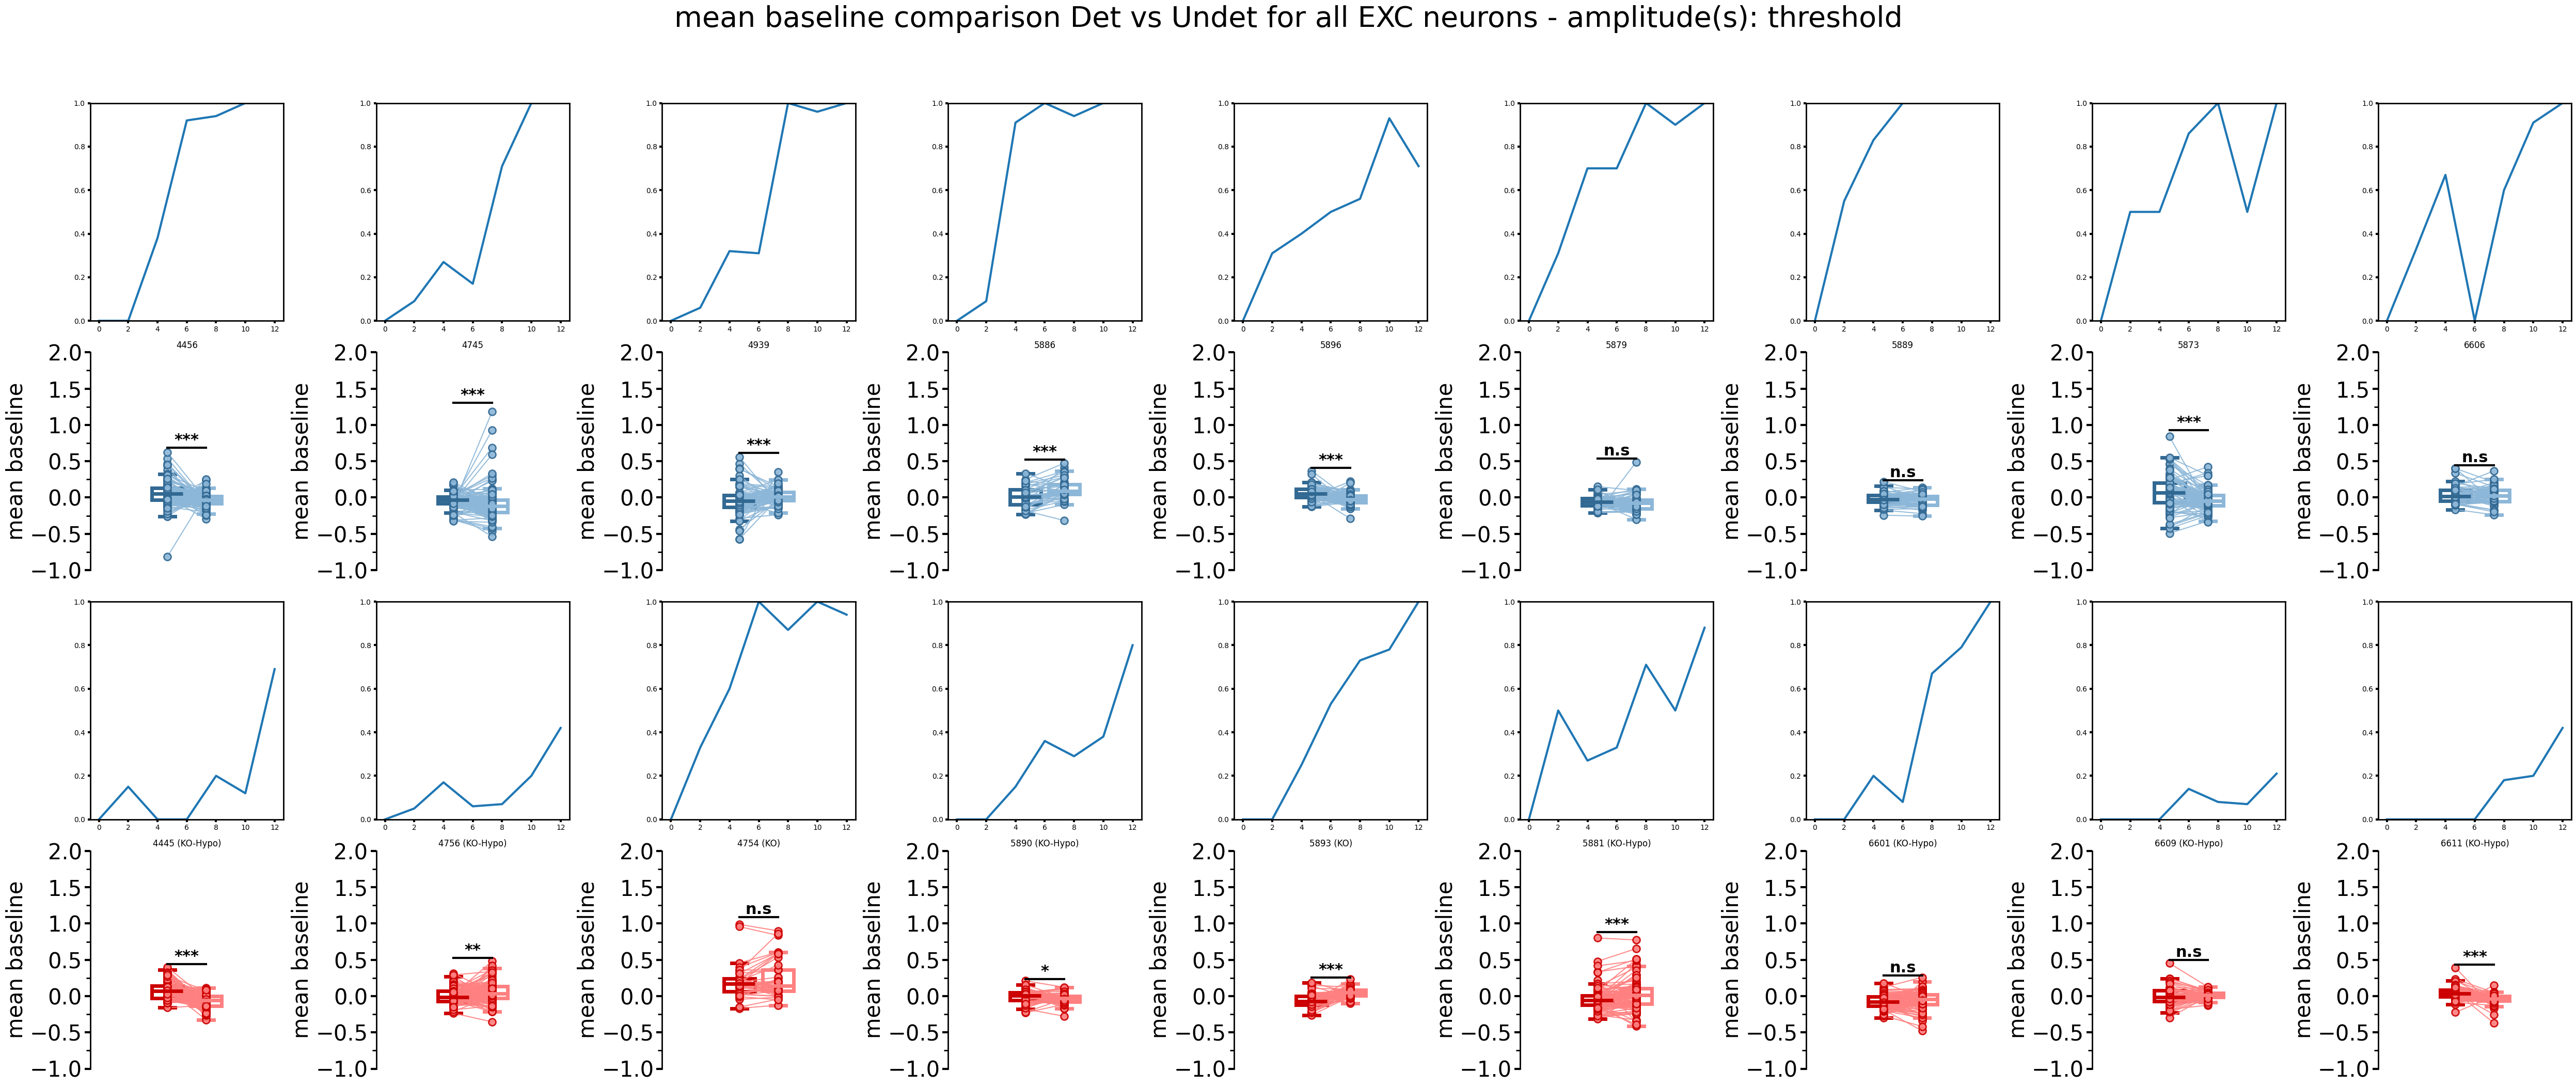

In [15]:
plot_baseline_comparison(recs, n_type="EXC", approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[-1,2])

In this figure the baseline before the detected stimulus (1st boxplot) is compared to the baseline before the undetected stimulus for all the different recording. The amplitude of the stimulus that is chosen for each comparison is manual defined from the observation of the psychometric curve plotted above the boxplots, it should have enough detected and undetected trials to be able to do the comparison. WT mice are on the first line and KO mice are on the second line.
We can observe that the baseline is significantly higher for 4 of 6 of the KO mice and 5 out of 7 WT mice. It seems that could be an explanation of the failed detection for both genotype.

### Stimulation above mean WT threshold amplitudes

Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9763190022488882, pvalue=0.0737500403291037)
ShapiroResult(statistic=0.9902124862127233, pvalue=0.6947952550910624)
TtestResult(statistic=-5.238825803985068, pvalue=9.40424555149343e-07, df=97)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9760458899546198, pvalue=0.023598746470285405)
ShapiroResult(statistic=0.9261268854114758, pvalue=3.160531576142122e-06)
WilcoxonResult(statistic=1123.0, pvalue=1.4775045096765039e-12)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9510738081596508, pvalue=0.00018815343956862034)
ShapiroResult(statistic=0.949853499078723, pvalue=0.0001522268123293097)
WilcoxonResult(statistic=1658.0, pvalue=1.9483051400817856e-08)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9588908025344187, pvalue=0.0005516291529950043)
ShapiroResult(statistic=0.9497889730940281, pvalue=0.00010242078070584058)
WilcoxonResult(statistic=4147.0, pvalue=0.685982

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


--- mean baseline ---
ShapiroResult(statistic=0.9030096404228917, pvalue=1.4519044662107663e-06)
ShapiroResult(statistic=0.9151539105564065, pvalue=5.92658165615387e-06)
WilcoxonResult(statistic=1213.0, pvalue=1.4375199131811305e-06)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9814946653306916, pvalue=0.6038379383610084)
ShapiroResult(statistic=0.9836722747423952, pvalue=0.7021516675046726)
TtestResult(statistic=-0.8571195137373606, pvalue=0.39546850247209964, df=50)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9754341623083477, pvalue=0.0519545435590091)
ShapiroResult(statistic=0.9556148510910626, pvalue=0.0016379523447176564)
WilcoxonResult(statistic=672.0, pvalue=4.1233278516479634e-11)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9810780553127237, pvalue=0.4531995723953094)
ShapiroResult(statistic=0.9845873372785925, pvalue=0.6275659578654902)
TtestResult(statistic=-1.5359834915772368, pvalue=0.12971348181147083, df=61

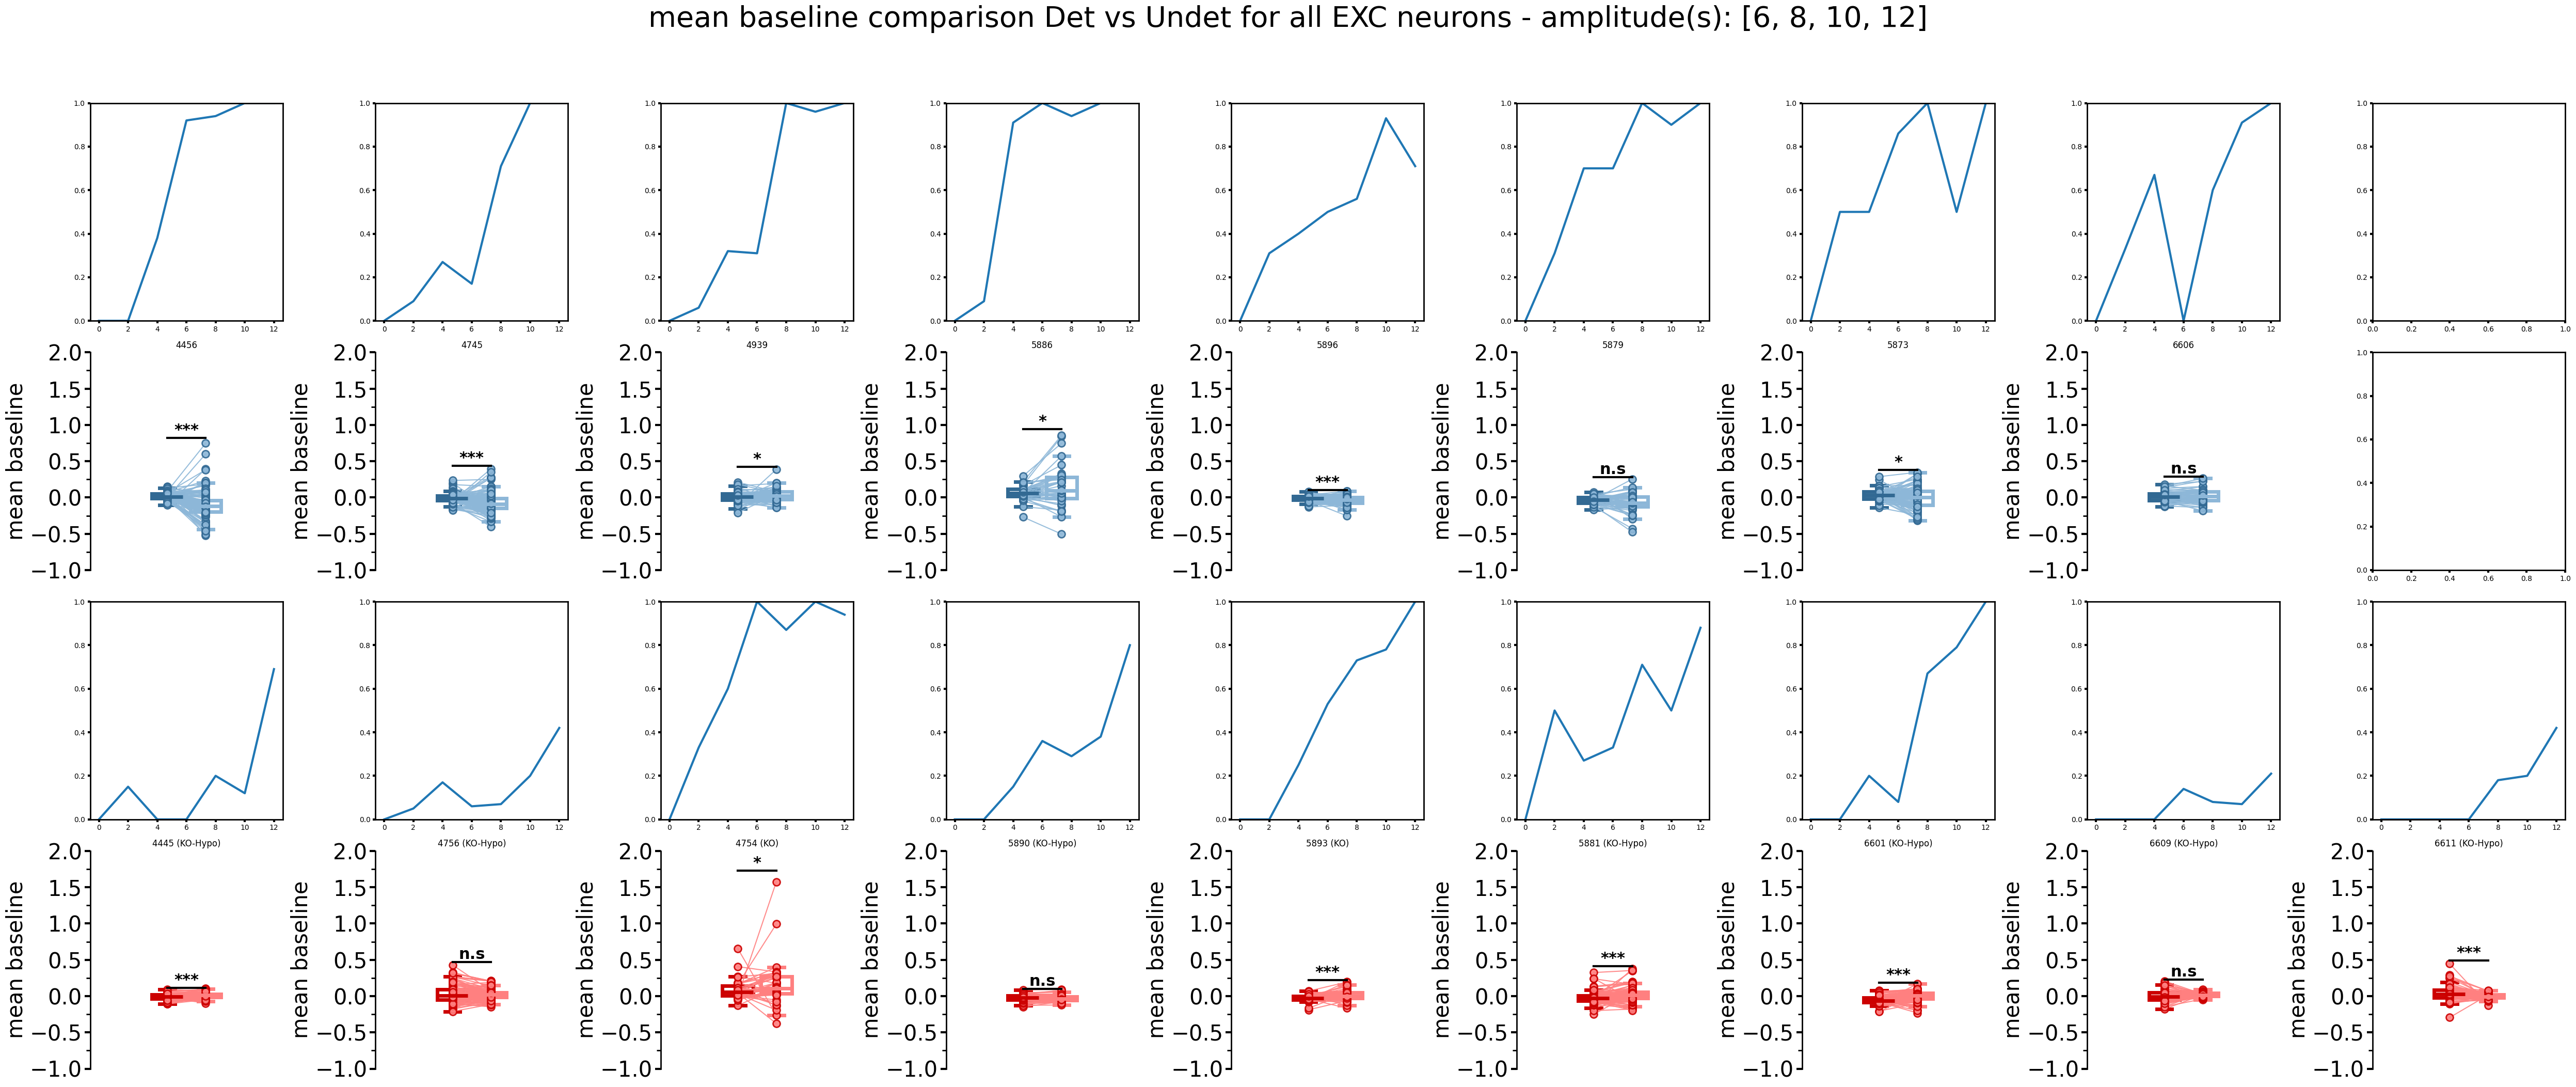

In [16]:
plot_baseline_comparison(recs, n_type="EXC", approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,2])

## Std of baseline

### Stimulation at threshold amplitude

Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.9793046540922041, pvalue=0.1251147025385096)
ShapiroResult(statistic=0.9473922990599599, pvalue=0.000647377277732976)
WilcoxonResult(statistic=914.0, pvalue=8.502964056383961e-08)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.8716979012678682, pvalue=4.308964146741886e-09)
ShapiroResult(statistic=0.7063335543527728, pvalue=1.3009673782351353e-14)
WilcoxonResult(statistic=2456.0, pvalue=0.0001092187788373137)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.9340466222841364, pvalue=1.1857469317267745e-05)
ShapiroResult(statistic=0.8263728947822355, pvalue=7.765327368987862e-11)
WilcoxonResult(statistic=1903.0, pvalue=5.36249863955951e-07)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.9417232251230399, pvalue=2.5796865579006665e-05)
ShapiroResult(statistic=0.8730734642448557, pvalue=3.307477129433545e-09)
WilcoxonResult(statistic=2698.0, pvalue=0.00018920930957652907)
Bo

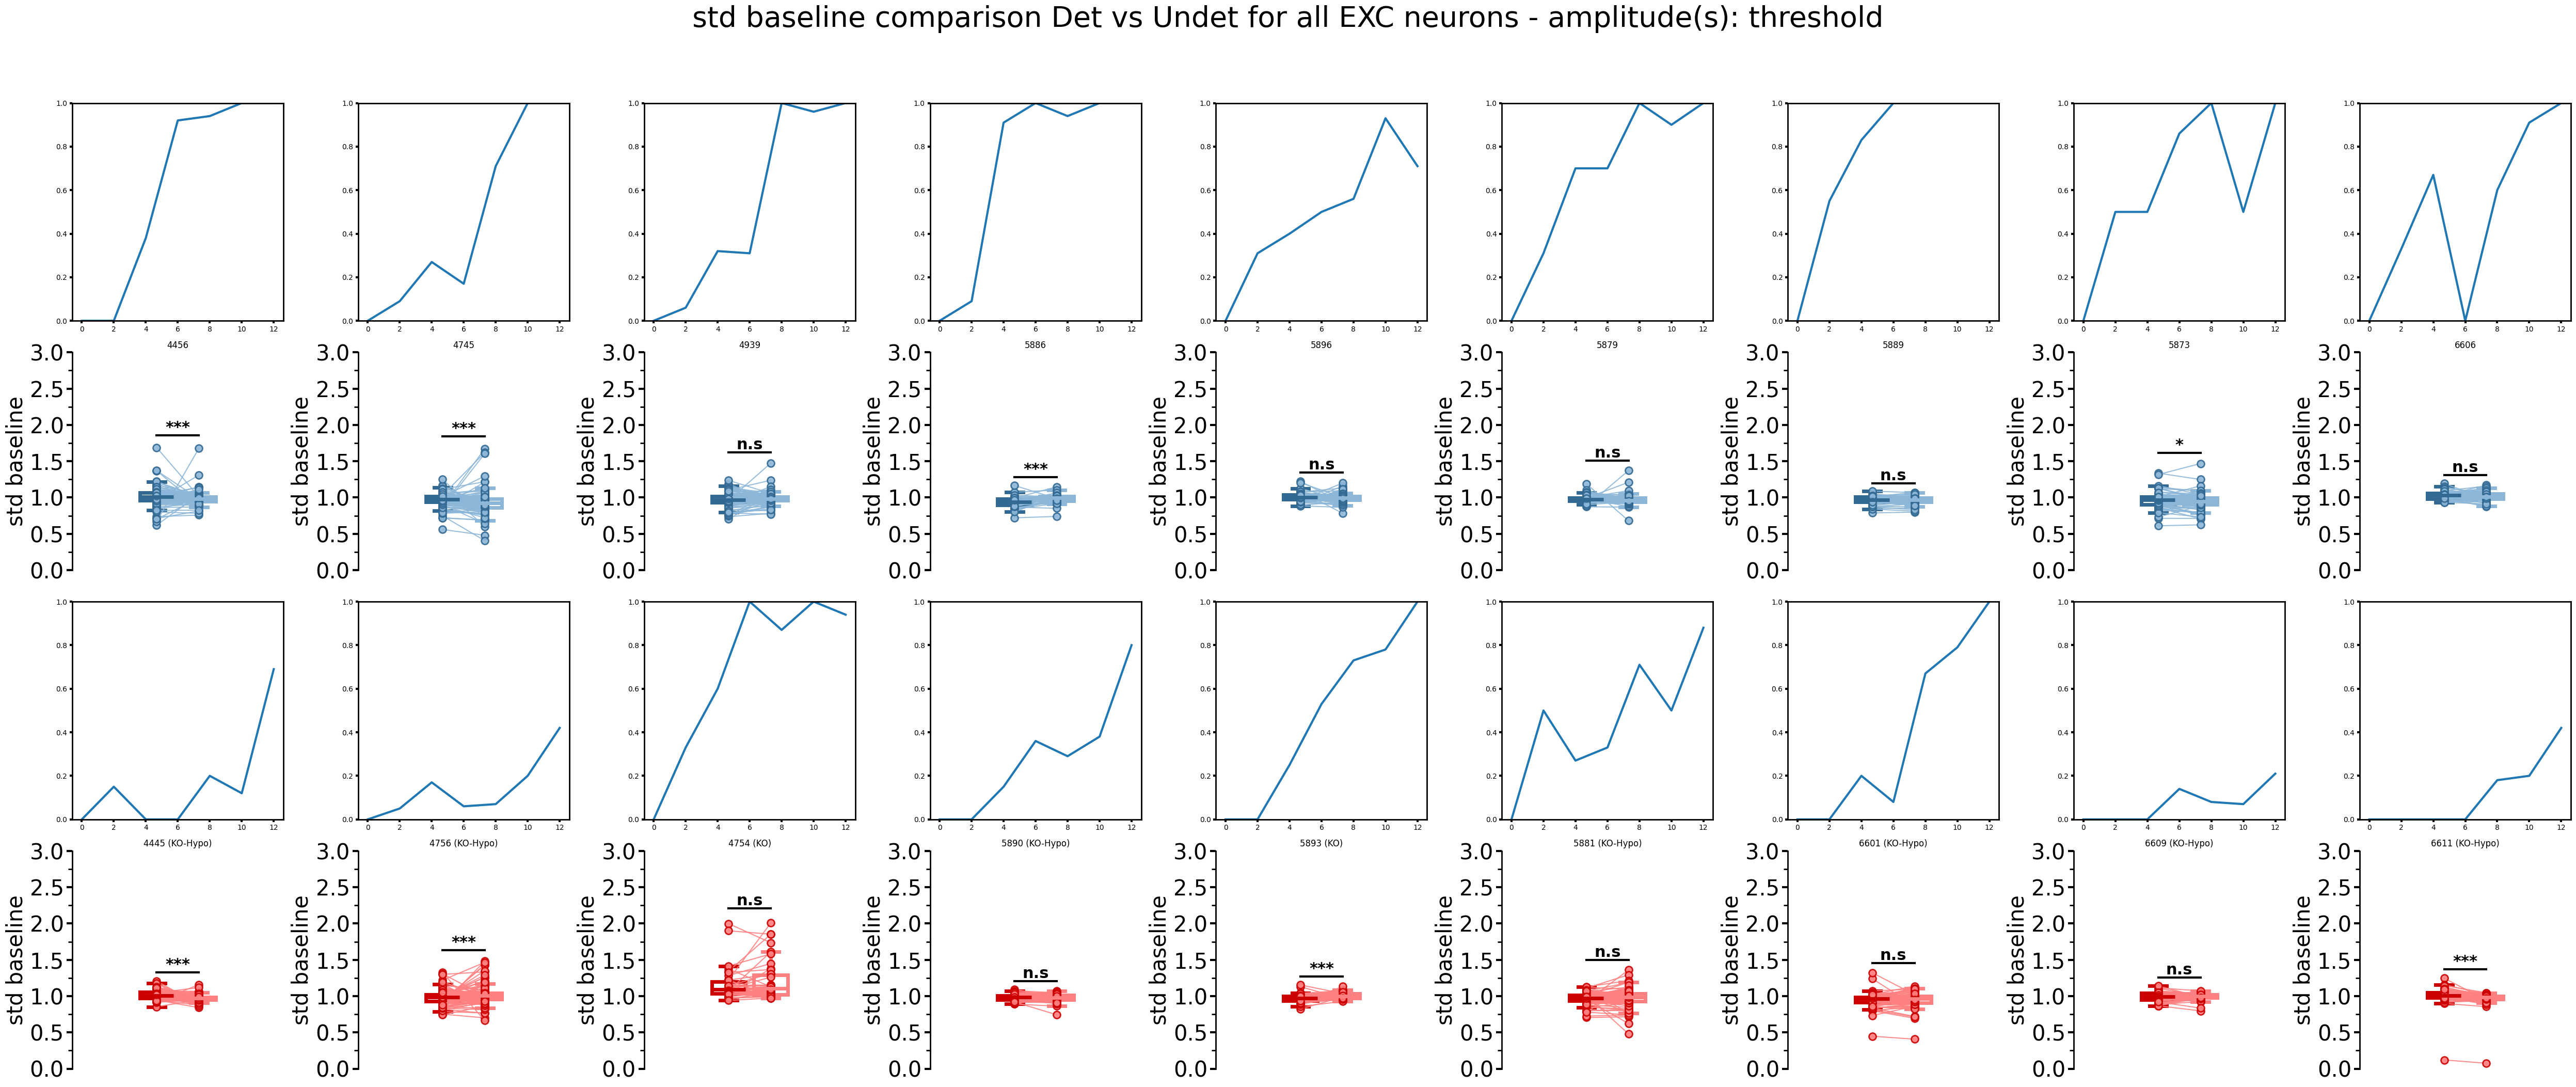

In [17]:
plot_baseline_comparison(recs, n_type="EXC", approx="std", stim_ampl="threshold", only_mlr_signif=False, ylim=[0,3])

The comparisons of the standard deviation of the baseline for KO group are still the same but for the WT group only 3 out of 7 are still significant

### Stimulation above mean WT threshold amplitude

Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.9722675877330089, pvalue=0.03605874976419198)
ShapiroResult(statistic=0.9058986576530863, pvalue=3.307458606536943e-06)
WilcoxonResult(statistic=1677.0, pvalue=0.007992952191382338)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.9212095490426829, pvalue=1.5797235750473705e-06)
ShapiroResult(statistic=0.8940901140589418, pvalue=5.050684748458775e-08)
WilcoxonResult(statistic=848.0, pvalue=1.0076670333956055e-14)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.8387612924566913, pvalue=2.2753651951591046e-10)
ShapiroResult(statistic=0.8684414919813028, pvalue=3.800197410879246e-09)
WilcoxonResult(statistic=1161.0, pvalue=7.858546920803473e-12)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.9311816415231519, pvalue=4.877319798277725e-06)
ShapiroResult(statistic=0.832585922816149, pvalue=6.653824250938e-11)
WilcoxonResult(statistic=2647.0, pvalue=0.00011803910831968987)
Boxp

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.6196450408489846, pvalue=6.1061265860410656e-15)
ShapiroResult(statistic=0.26969941181867485, pvalue=2.5166471787599045e-20)
WilcoxonResult(statistic=840.0, pvalue=1.4768630175416455e-09)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.8962754825940802, pvalue=7.475602104594713e-05)
ShapiroResult(statistic=0.17684276949053834, pvalue=6.973411196895823e-17)
WilcoxonResult(statistic=480.0, pvalue=0.0004995496108499916)
Boxplot plotting.
--- std baseline ---
ShapiroResult(statistic=0.5297049332888977, pvalue=5.731535907811493e-15)
ShapiroResult(statistic=0.5047744440995683, pvalue=2.337481770507274e-15)
WilcoxonResult(statistic=1118.0, pvalue=0.002933025578739768)


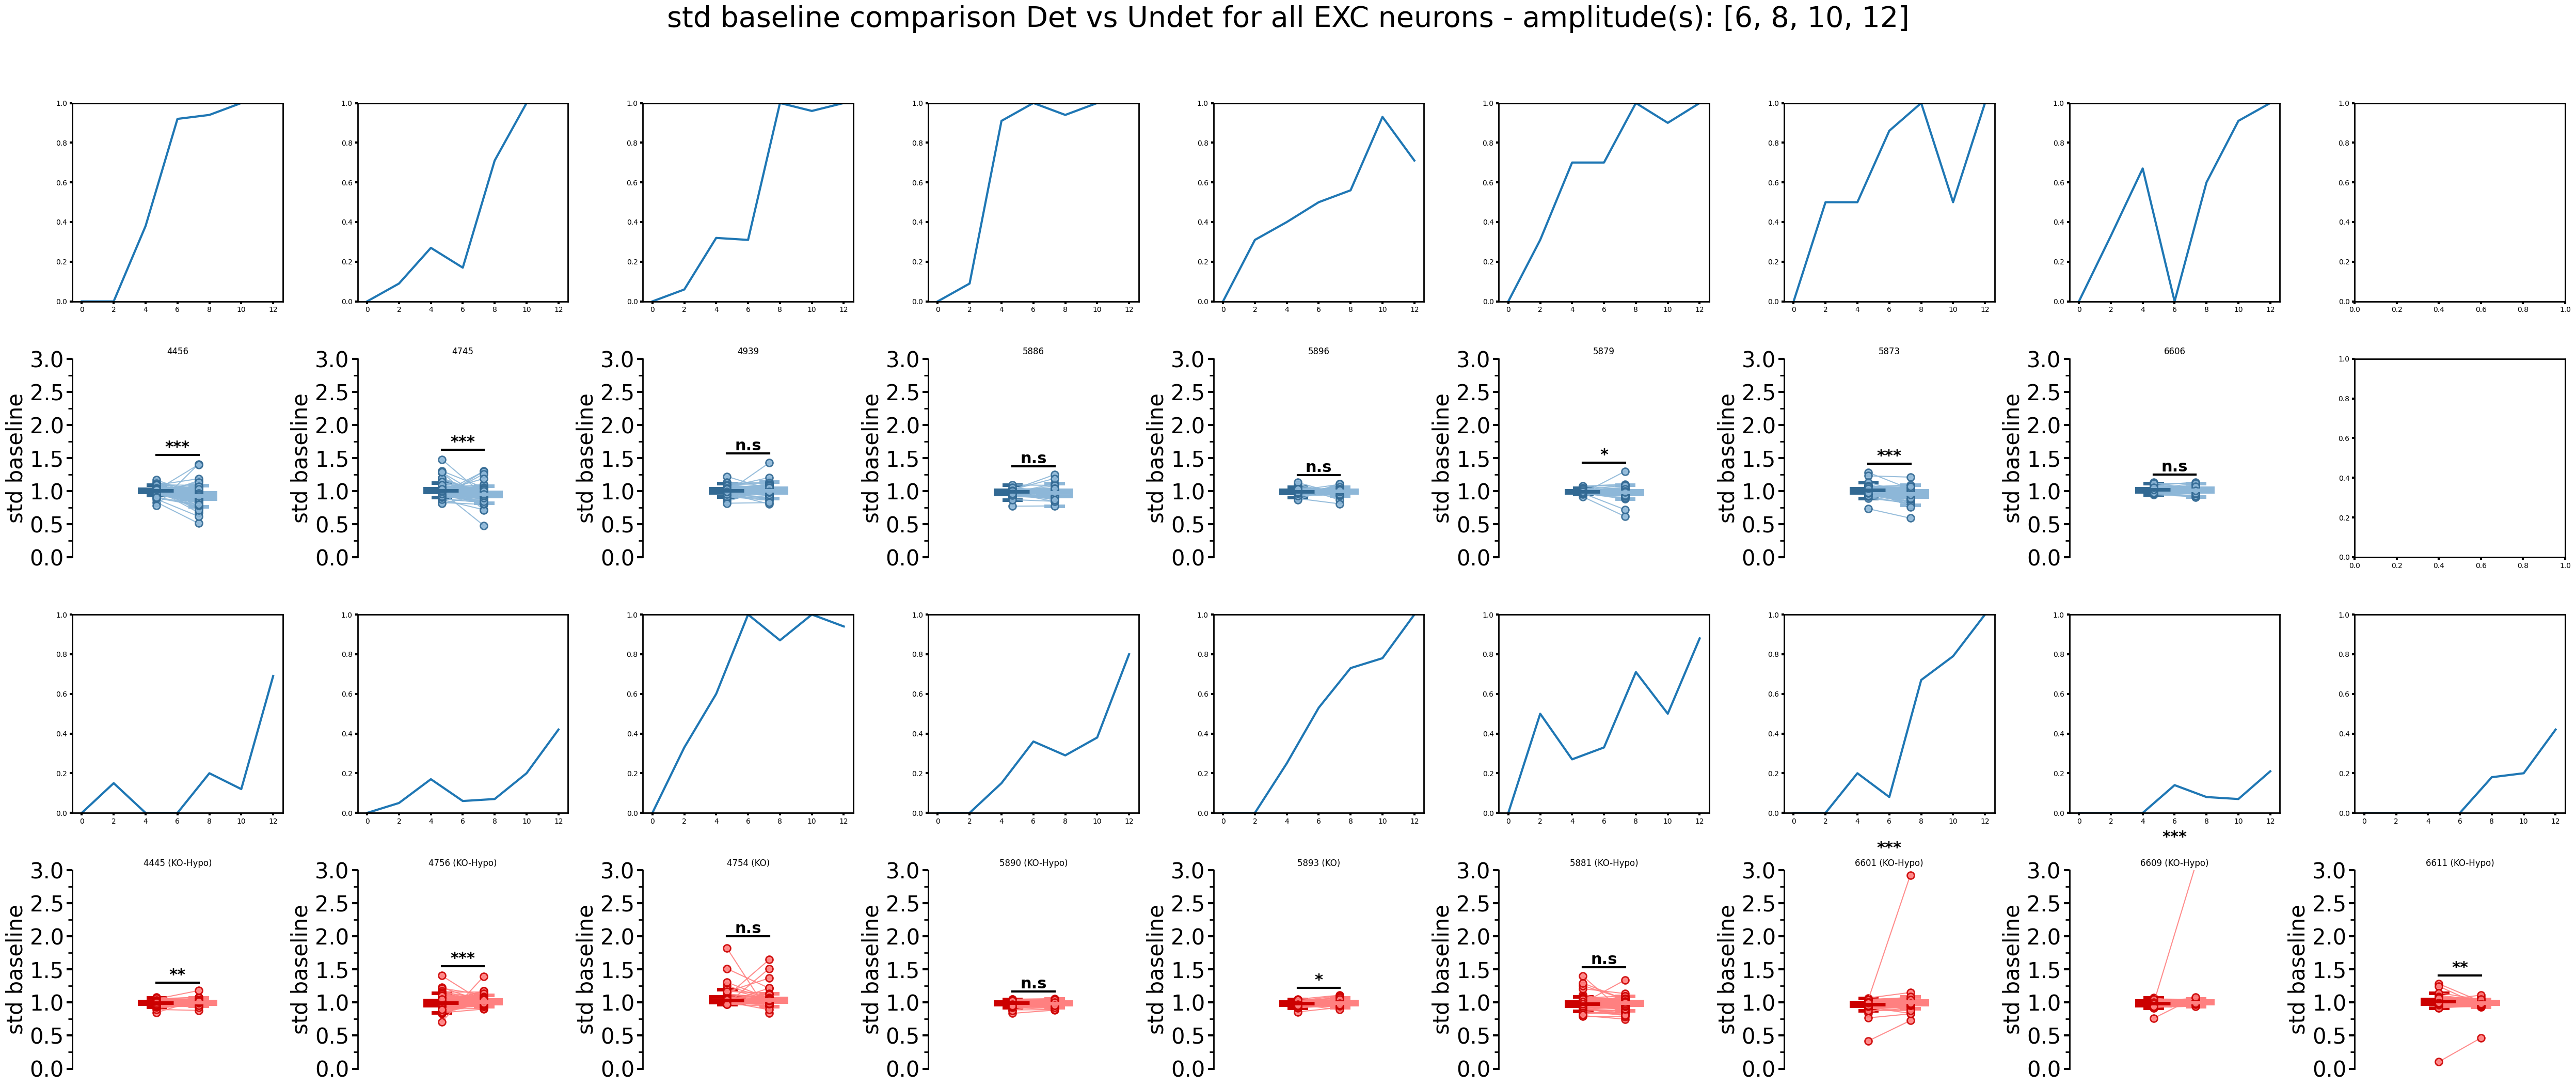

In [18]:
plot_baseline_comparison(recs, n_type="EXC", approx="std", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[0, 3])

## MLR significant and inhibitory neurons

The next step is to compare only the neurons that were found significant with the MLR analysis, maybe the neurons silent or non-responding parasite the comparison of the baseline. We test here for all MLR neurons independently of their mlr labels

MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9849505889762874, pvalue=0.7189008416382192)
ShapiroResult(statistic=0.9896865468218221, pvalue=0.9177353178642925)
TtestResult(statistic=-7.224263881631916, pvalue=1.7809841858127169e-09, df=54)
MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9764120395168782, pvalue=0.03703970589546192)
ShapiroResult(statistic=0.9221963737618541, pvalue=4.169191103155719e-06)
WilcoxonResult(statistic=950.0, pvalue=1.020422660282523e-11)
MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9456197626153723, pvalue=0.00024233400357464568)
ShapiroResult(statistic=0.9709843400226433, pvalue=0.01832125610054967)
WilcoxonResult(statistic=800.0, pvalue=5.079060962625384e-11)
MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9816867132080478, pvalue=0.6757034597261782)
ShapiroResult(statisti

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.964718627030784, pvalue=0.051279386220538244)
ShapiroResult(statistic=0.9199998523236359, pvalue=0.0003248888936167164)
WilcoxonResult(statistic=491.0, pvalue=3.082813466368453e-05)
MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9416179961554331, pvalue=0.5711539878155789)
ShapiroResult(statistic=0.9449068613412548, pvalue=0.6087841784745713)
TtestResult(statistic=-0.4710060753367645, pvalue=0.648843578818088, df=9)
MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8613390091974883, pvalue=0.07913235878658029)
ShapiroResult(statistic=0.9327752480547864, pvalue=0.47573811333756794)
TtestResult(statistic=0.20731190334658356, pvalue=0.8403810696762658, df=9)
MLR model already computed
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9609166398995971, pvalue=0.45711713139687943)
ShapiroResult(s

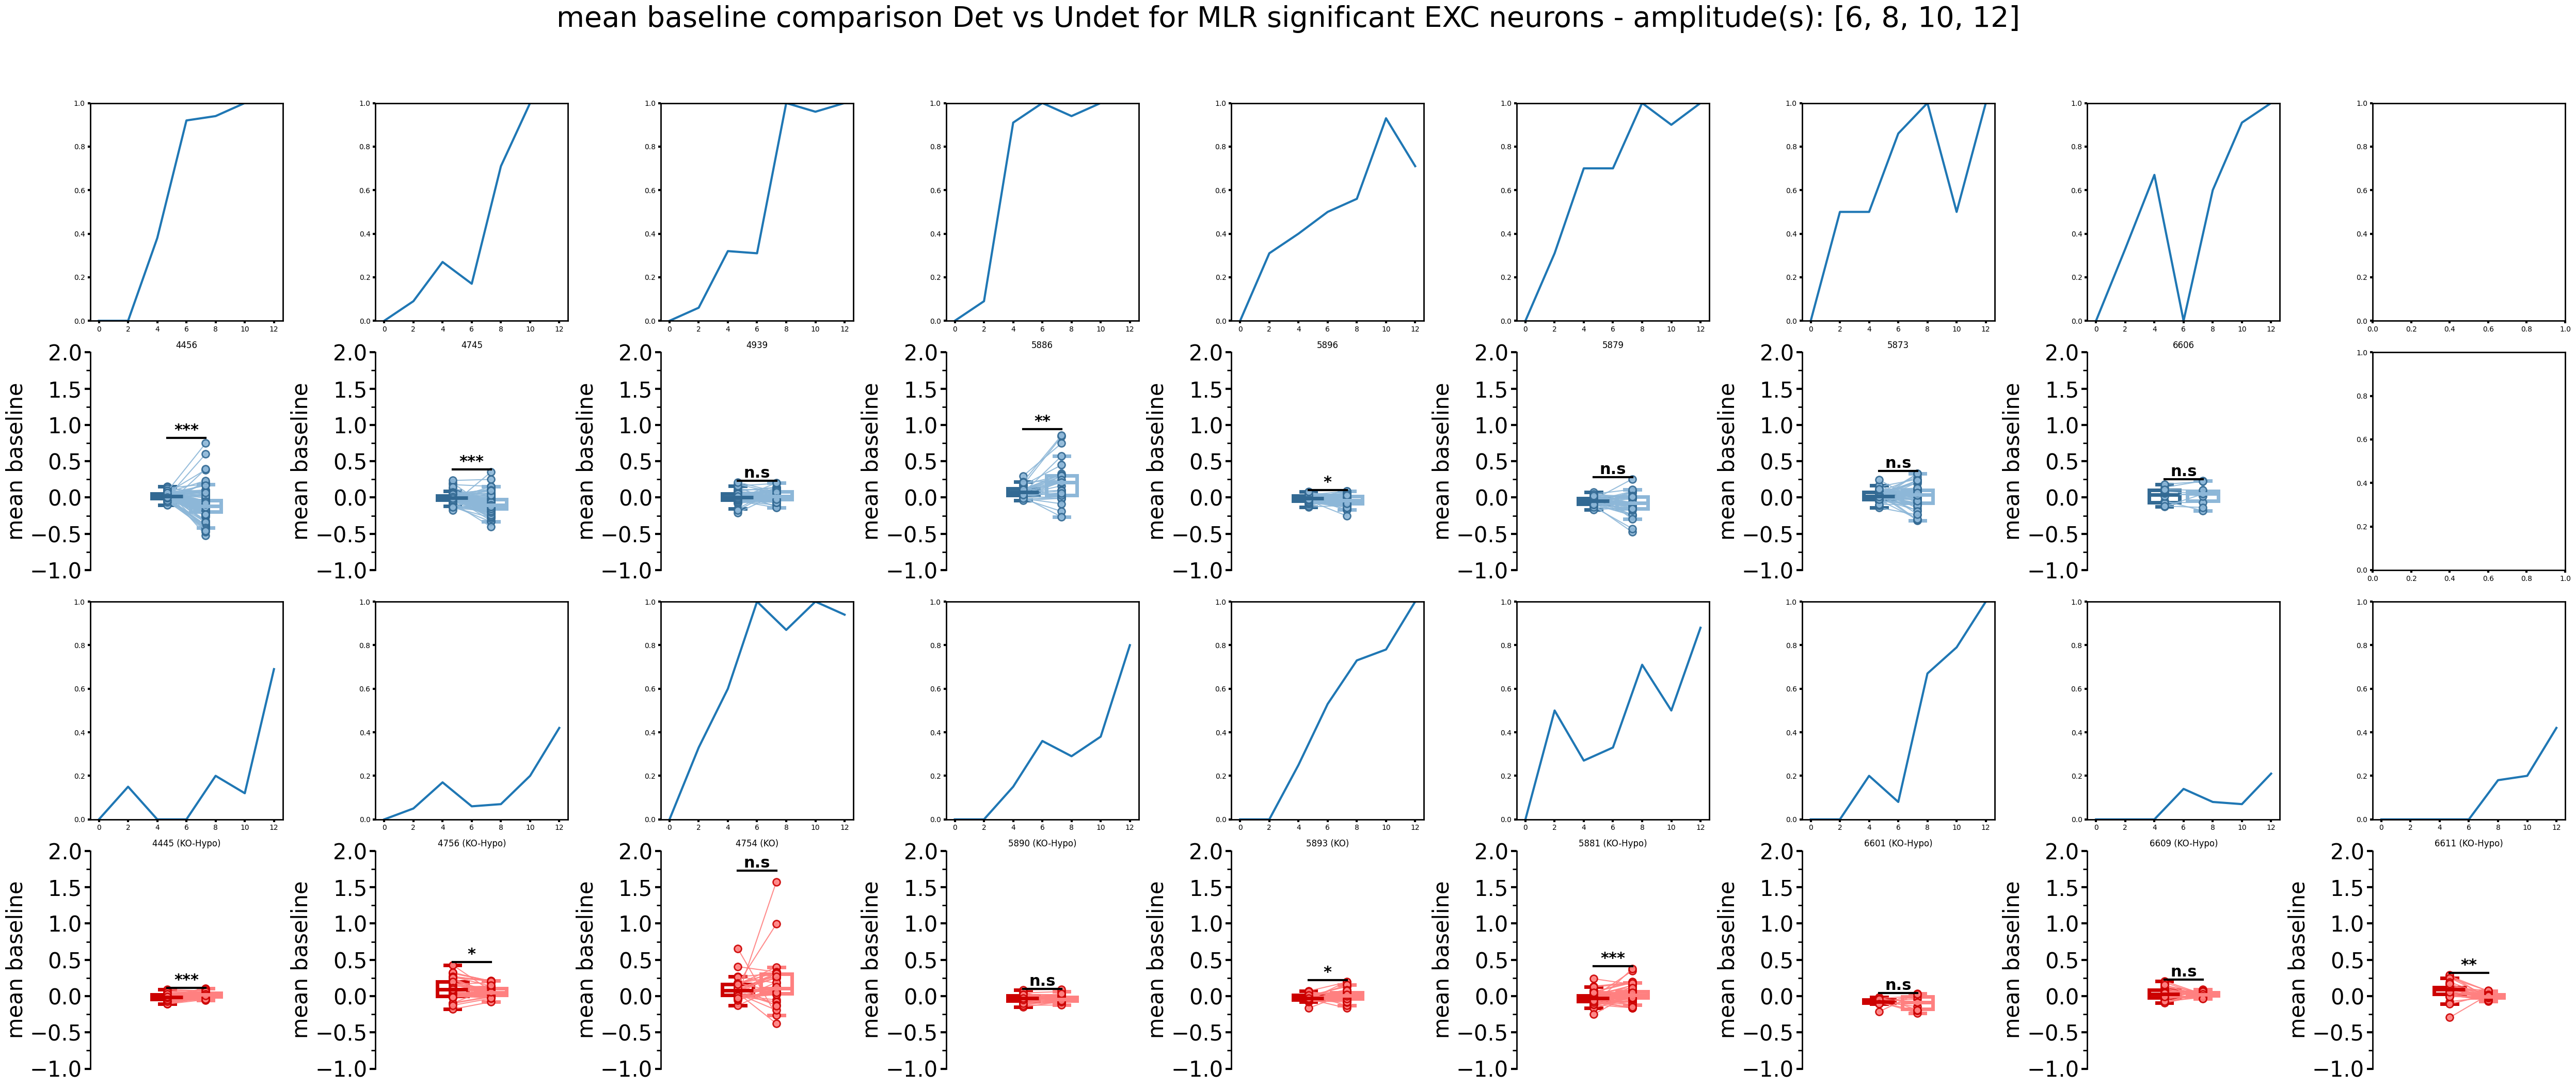

In [19]:
plot_baseline_comparison(recs, n_type="EXC", approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=True, ylim=[-1,2])

The global trend seems to be the same in KO mice but lot less significant animals. The result is opposite of what we hypothesised before. It seems even that in WT group the dynamic is opposite, the firing neurons have lower baseline in non detected stimulus. Similar analysis should be made with a discrimination of the  clusters of neurons 



Testing with all inhibitory cells

Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9480082672056562, pvalue=0.5302330409227138)
ShapiroResult(statistic=0.9036912797730576, pvalue=0.127600334692832)
TtestResult(statistic=5.569438566951188, pvalue=9.081360161712359e-05, df=13)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.6237617351912734, pvalue=6.658841497235899e-05)
ShapiroResult(statistic=0.9291545983487531, pvalue=0.29691440719597195)
WilcoxonResult(statistic=23.0, pvalue=0.067626953125)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9155526901647015, pvalue=0.08138537874978839)
ShapiroResult(statistic=0.9220009065632434, pvalue=0.10827860097597786)
TtestResult(statistic=0.38496725021872685, pvalue=0.7045371829665535, df=19)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9780027339819587, pvalue=0.9744290889791591)
ShapiroResult(statistic=0.9526368677060782, pvalue=0.6757960759776507)
TtestResult(statistic=-1.5478363784583413, pvalue=0.149933

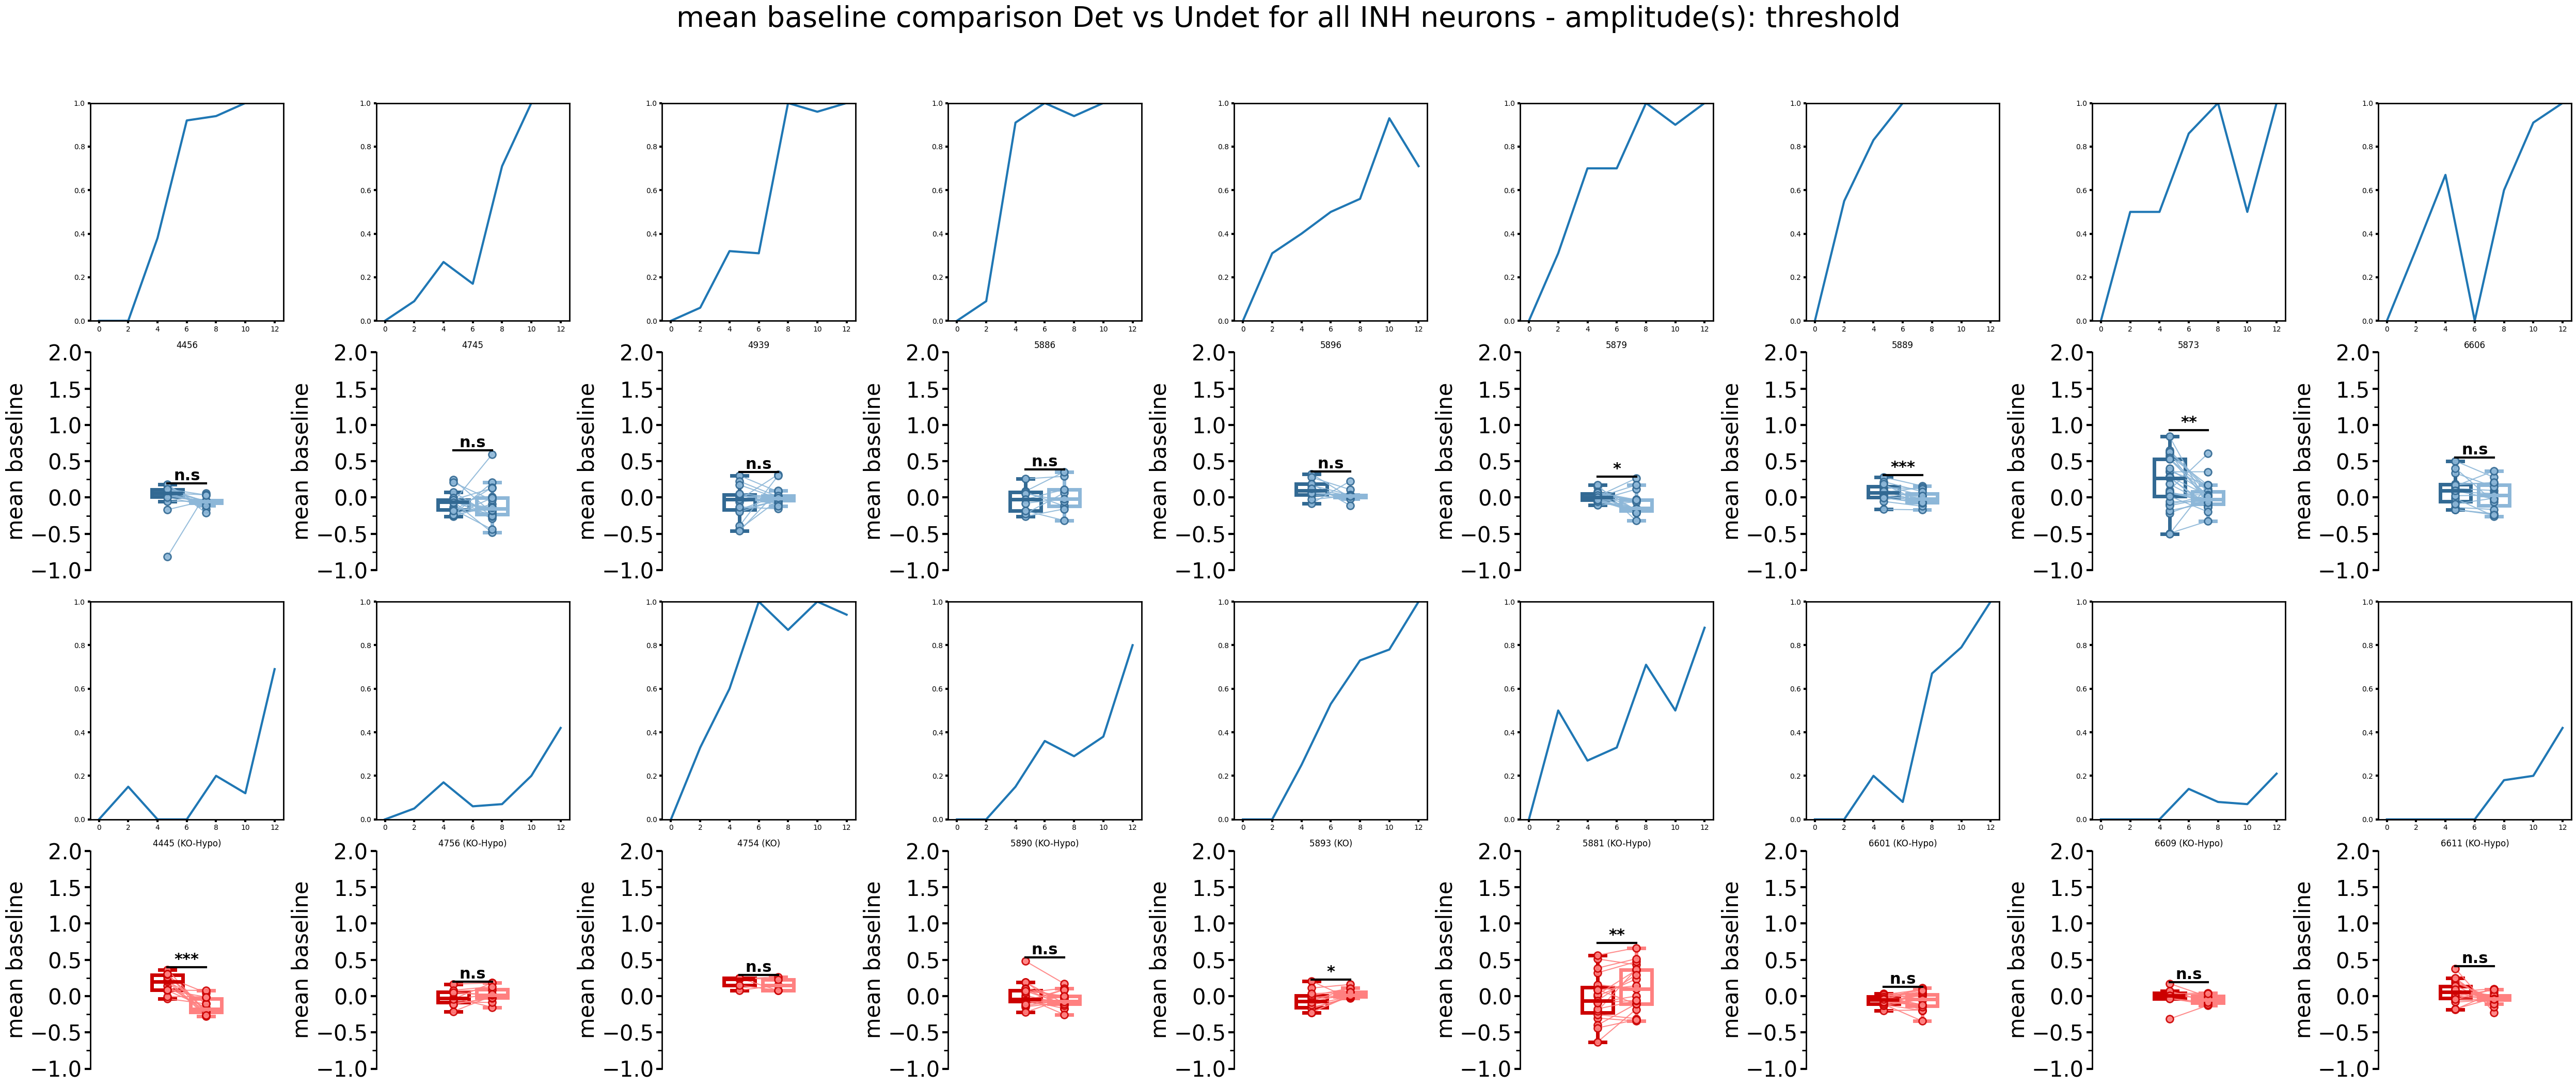

In [20]:
plot_baseline_comparison(recs, n_type="INH", approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[-1,2])

# Activation vs. inhibition of the neuron for all stimuli in the same animal

___

Comparison of baseline for all exc neurons in between when it is activated and when it is inhibited

In [46]:
def plot_diff_neuron_act(recs, n_type="EXC", first_group=1, second_group=-1, y_lim=[0,2], responsive_neur=False):
    label_dict = {0: "non_active", 1: "activated", -1: "inhibited"}
    y, i = 0, 0
    fig, ax = plt.subplots(4, 9, figsize=(50, 20))
  
    for rec  in recs.values():
        # if rec.filename == 4456:
        #     continue
        trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
        if responsive_neur:
            ids_resp, ids_inh = idx_resp_neur(rec, n_type=n_type)
            if len(ids_resp)<3:
                continue
            trace = trace[ids_resp] if n_type == "EXC" else trace[ids_resp]
        #  get all the bsl before stim of the corresponding amp stim
        act_bsl = []
        nact_bsl = []
        for idx, n_df in enumerate(trace):
            resp_n = np.array(rec.matrices[n_type]["Responsivity"][idx])
            act_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == first_group ] - int(1 * rec.sf), rec.stim_time[resp_n == first_group ], int(1 * rec.sf), dtype=int)]
            nact_bsl_n = n_df[np.linspace(rec.stim_time[resp_n == second_group] - int(1 * rec.sf), rec.stim_time[resp_n == second_group], int(1 * rec.sf), dtype=int)]
            if np.count_nonzero(~np.isnan(act_bsl_n)) > 3 and np.count_nonzero(~np.isnan(nact_bsl_n))> 3:
                act_bsl.append(np.mean(act_bsl_n[~np.isnan(act_bsl_n)]))
                nact_bsl.append(np.mean(nact_bsl_n[~np.isnan(nact_bsl_n)]))
        if rec.genotype == "WT":
            pbh.psycho_like_plot(rec, roi_info, ax[0, i])
            ppt.paired_boxplot(ax[1, i], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",colors=[ppt.wt_color, ppt.light_wt_color],ylim=[-1, 6], allow_stats_skip=True)
            ax[1, i].set_ylim(y_lim)
            i += 1
        else:
            pbh.psycho_like_plot(rec, roi_info, ax[2, y])
            ppt.paired_boxplot(ax[3, y], np.array(act_bsl), np.array(nact_bsl), "mean baseline","",ylim=[-1,6], allow_stats_skip=True)
            ax[3, y].set_ylim(y_lim)
            y += 1
                
    fig.suptitle(f"Mean baseline comparison {label_dict[first_group]} vs {label_dict[second_group]} for all exc neurons", y=1.05, fontsize=26)
    fig.tight_layout()

In [45]:
test = [[1, 2, 3, 4],
        [5, 6, np.NaN, 8],
        [9, 10, 11, 12]]

filtest = np.array(test)[~np.isnan(test)]

# for a, b in enumerate(test):
#     print(f"a: {a}, b: {b}")
filtest

array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 12.])

(30, 11)
(30, 5)
(30, 8)
(30, 0)
(30, 7)
(30, 2)
(30, 6)
(30, 0)
(30, 13)
(30, 0)
(30, 4)
(30, 0)
(30, 2)
(30, 0)
(30, 6)
(30, 1)
(30, 14)
(30, 14)
(30, 6)
(30, 7)
(30, 14)
(30, 10)
(30, 5)
(30, 3)
(30, 14)
(30, 12)
(30, 5)
(30, 0)
(30, 13)
(30, 1)
(30, 12)
(30, 9)
(30, 3)
(30, 1)
(30, 3)
(30, 0)
(30, 3)
(30, 0)
(30, 7)
(30, 7)
(30, 13)
(30, 15)
(30, 5)
(30, 0)
(30, 17)
(30, 13)
(30, 7)
(30, 0)
(30, 15)
(30, 11)
(30, 3)
(30, 0)
(30, 5)
(30, 1)
(30, 2)
(30, 0)
(30, 8)
(30, 0)
(30, 2)
(30, 0)
(30, 5)
(30, 0)
(30, 2)
(30, 0)
(30, 8)
(30, 0)
(30, 1)
(30, 0)
(30, 7)
(30, 1)
(30, 4)
(30, 2)
(30, 8)
(30, 6)
(30, 2)
(30, 1)
(30, 11)
(30, 13)
(30, 4)
(30, 0)
(30, 1)
(30, 0)
(30, 19)
(30, 11)
(30, 2)
(30, 0)
(30, 14)
(30, 5)
(30, 5)
(30, 2)
(30, 7)
(30, 0)
(30, 1)
(30, 0)
(30, 4)
(30, 0)
(30, 2)
(30, 1)
(30, 5)
(30, 0)
(30, 1)
(30, 1)
(30, 2)
(30, 2)
(30, 5)
(30, 0)
(30, 12)
(30, 10)
(30, 3)
(30, 1)
(30, 10)
(30, 0)
(30, 0)
(30, 1)
(30, 3)
(30, 2)
(30, 1)
(30, 0)
(30, 3)
(30, 0)
(30, 4)
(30, 1)


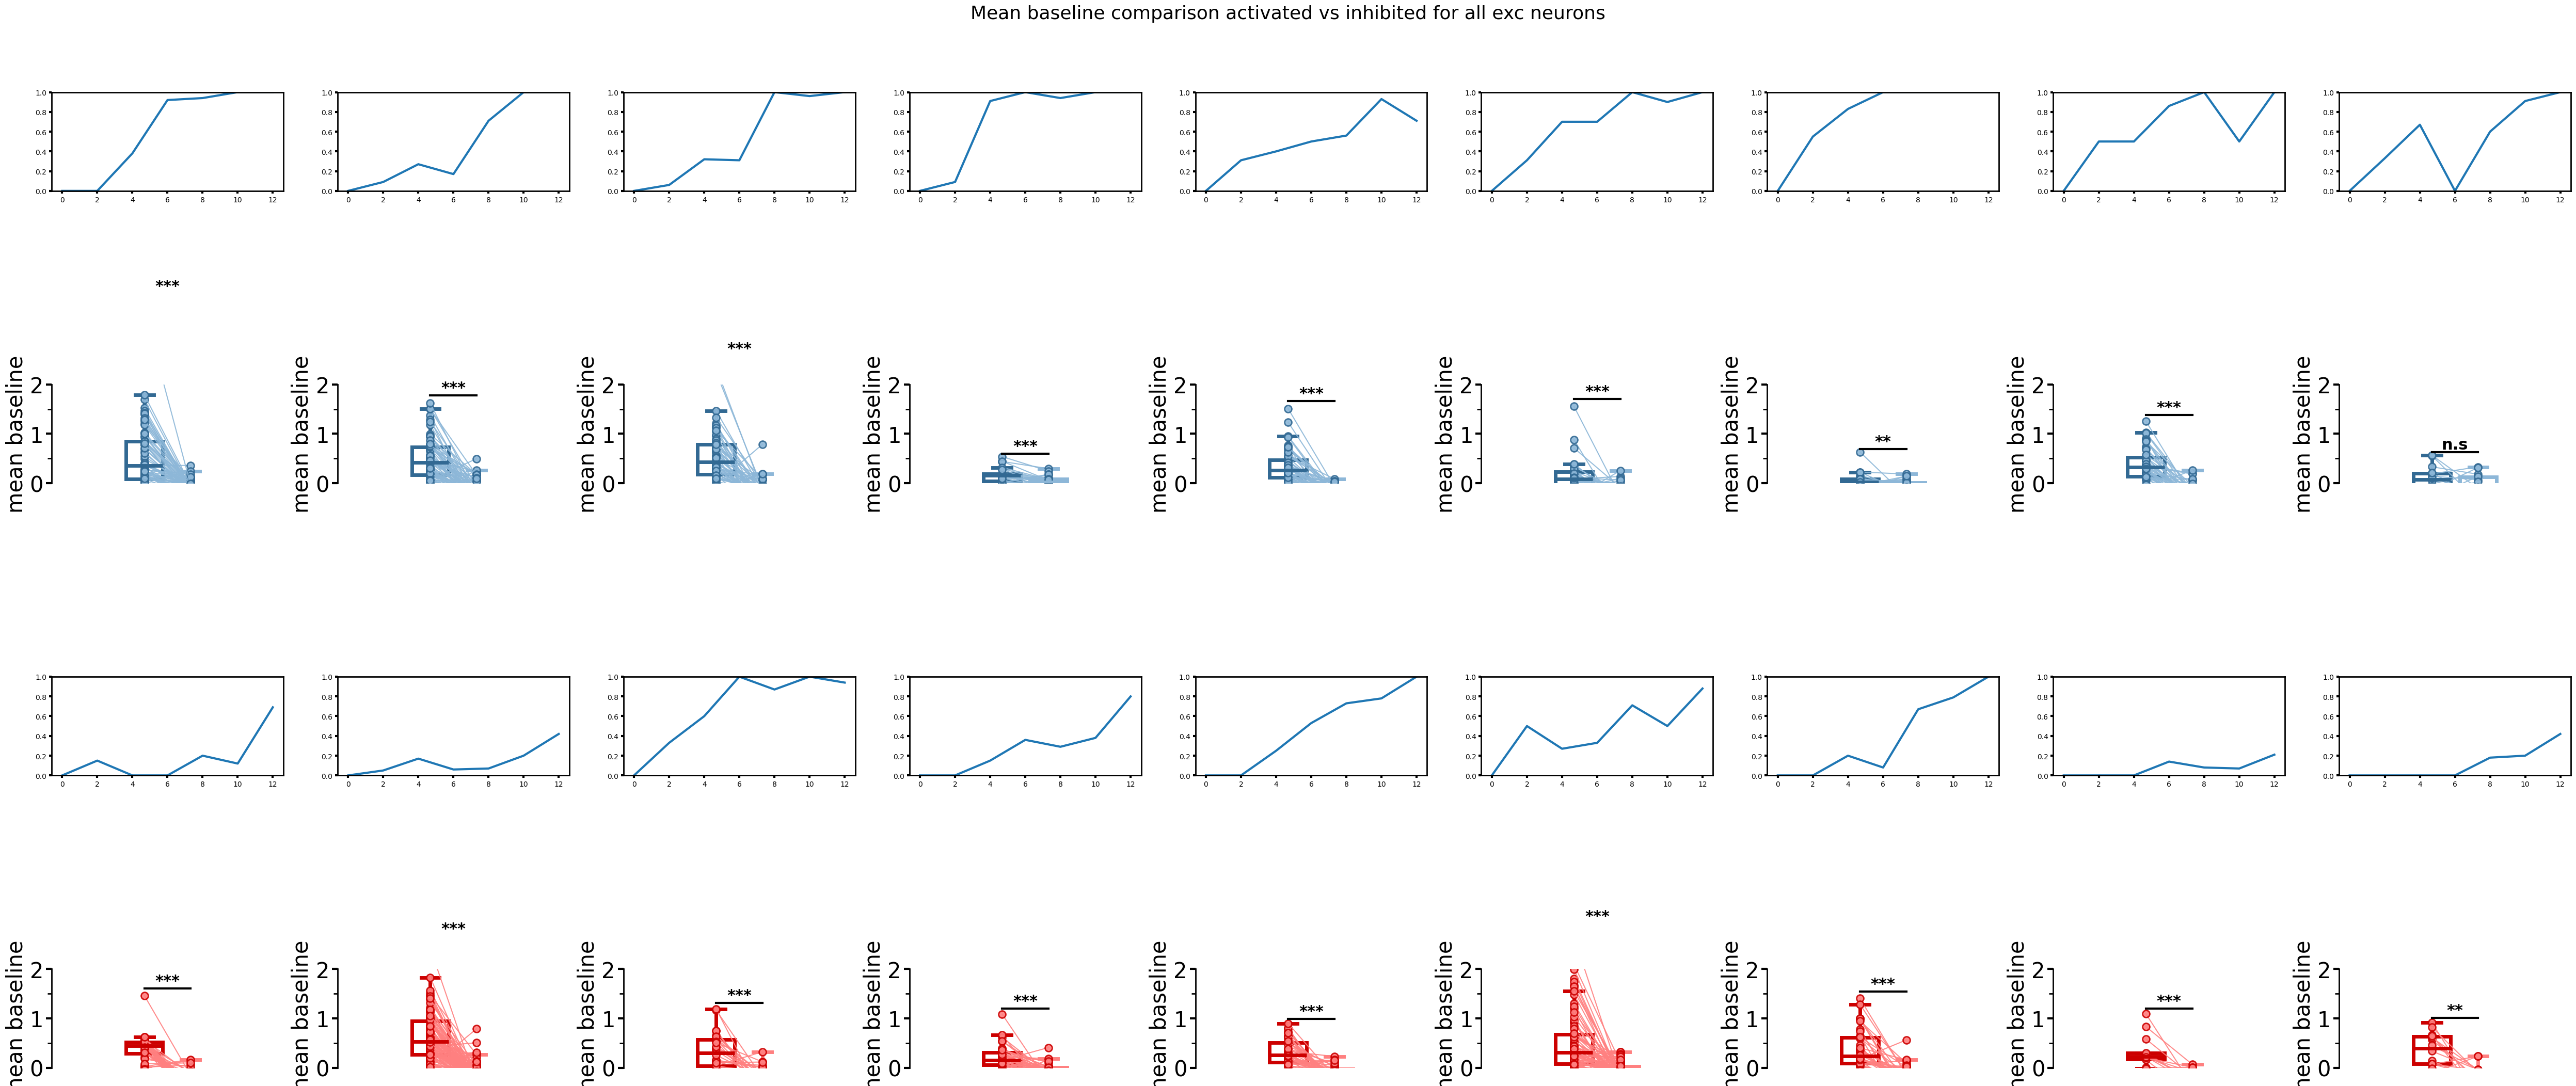

In [47]:
plot_diff_neuron_act(recs, n_type="EXC", first_group=1, second_group=-1)

Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9475234565714514, pvalue=0.03189170076457674)
ShapiroResult(statistic=0.9745397402767436, pvalue=0.37638577342043544)
WilcoxonResult(statistic=36.0, pvalue=3.537081738613779e-11)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9180841032867755, pvalue=1.960076916160509e-05)
ShapiroResult(statistic=0.9439283644849672, pvalue=0.000530018912017256)
WilcoxonResult(statistic=708.0, pvalue=8.988455842218232e-09)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9108240049717493, pvalue=1.7338257597024673e-05)
ShapiroResult(statistic=0.980858104822003, pvalue=0.22572193573584914)
WilcoxonResult(statistic=618.0, pvalue=4.1305594232235466e-08)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9421865365325732, pvalue=0.00015531813578445857)
ShapiroResult(statistic=0.9510207368036346, pvalue=0.000603875385848538)
WilcoxonResult(statistic=712.0, pvalue=1.322625178298508e-11)
Boxplot

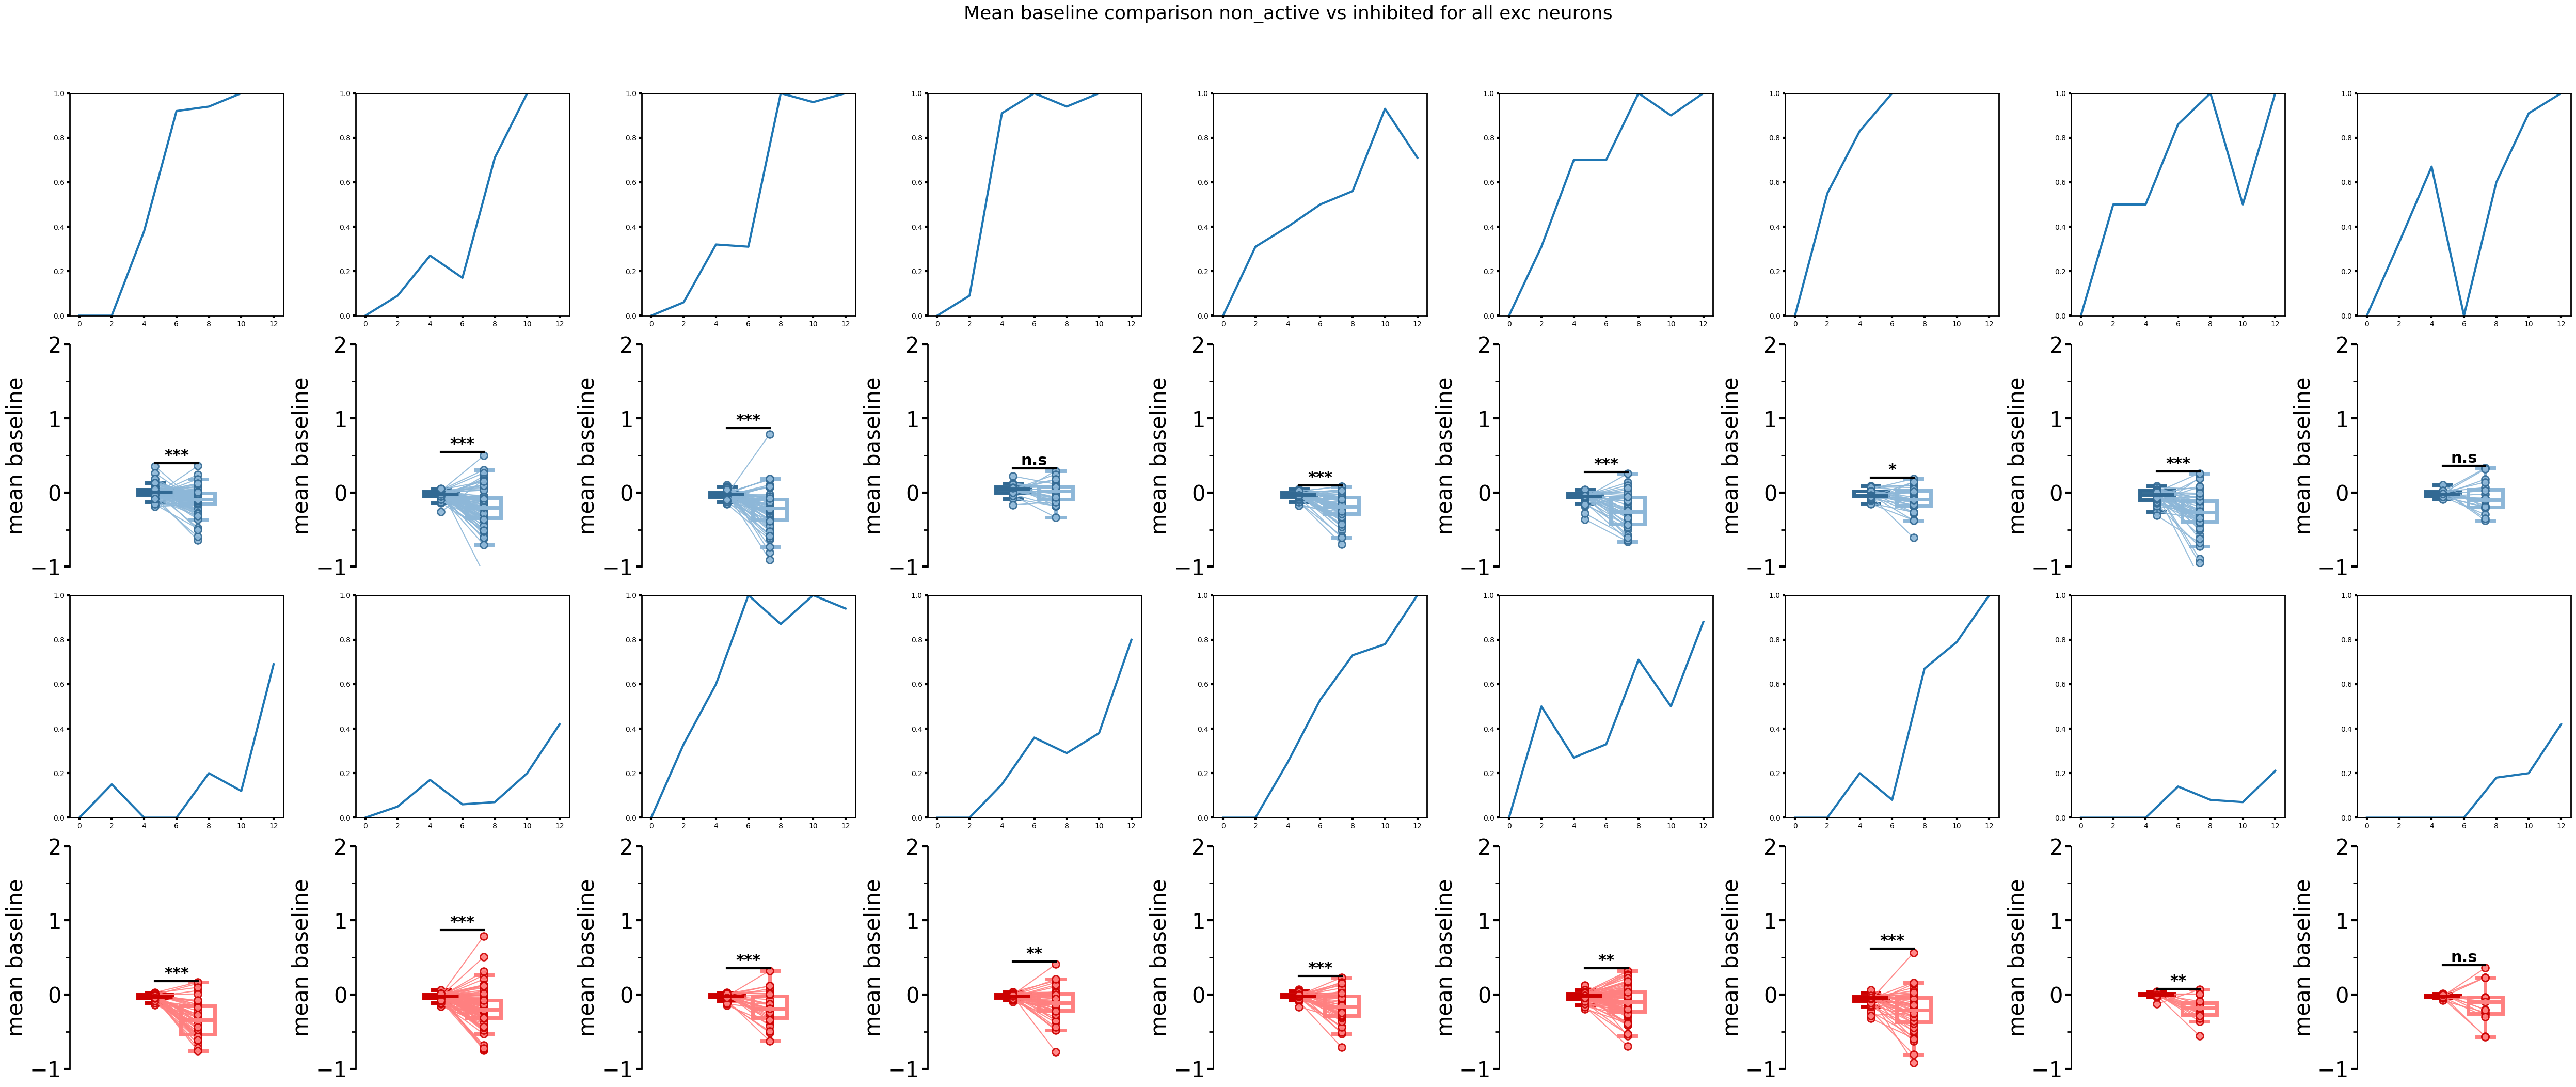

In [23]:
plot_diff_neuron_act(recs, n_type="EXC", first_group=0, second_group=-1,y_lim=[-1,2])

Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8892038964010172, pvalue=0.2705365404454773)
ShapiroResult(statistic=0.8834489706277815, pvalue=0.24220300573331421)
TtestResult(statistic=-1.4525569107408007, pvalue=0.19655942517246655, df=6)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8976642545353529, pvalue=0.005403588745990244)
ShapiroResult(statistic=0.8882689801424237, pvalue=0.0031550398676785016)
WilcoxonResult(statistic=150.0, pvalue=0.03248823946341872)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.7692443383487264, pvalue=0.02006996211526319)
ShapiroResult(statistic=0.9073148681558192, pvalue=0.3775945356941523)
WilcoxonResult(statistic=12.0, pvalue=0.8125)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9354307892393259, pvalue=0.32837086956455186)
ShapiroResult(statistic=0.9442069330204206, pvalue=0.4382183400115297)
TtestResult(statistic=-2.8421759404059403, pvalue=0.013049734520654286, df=14)
Bo

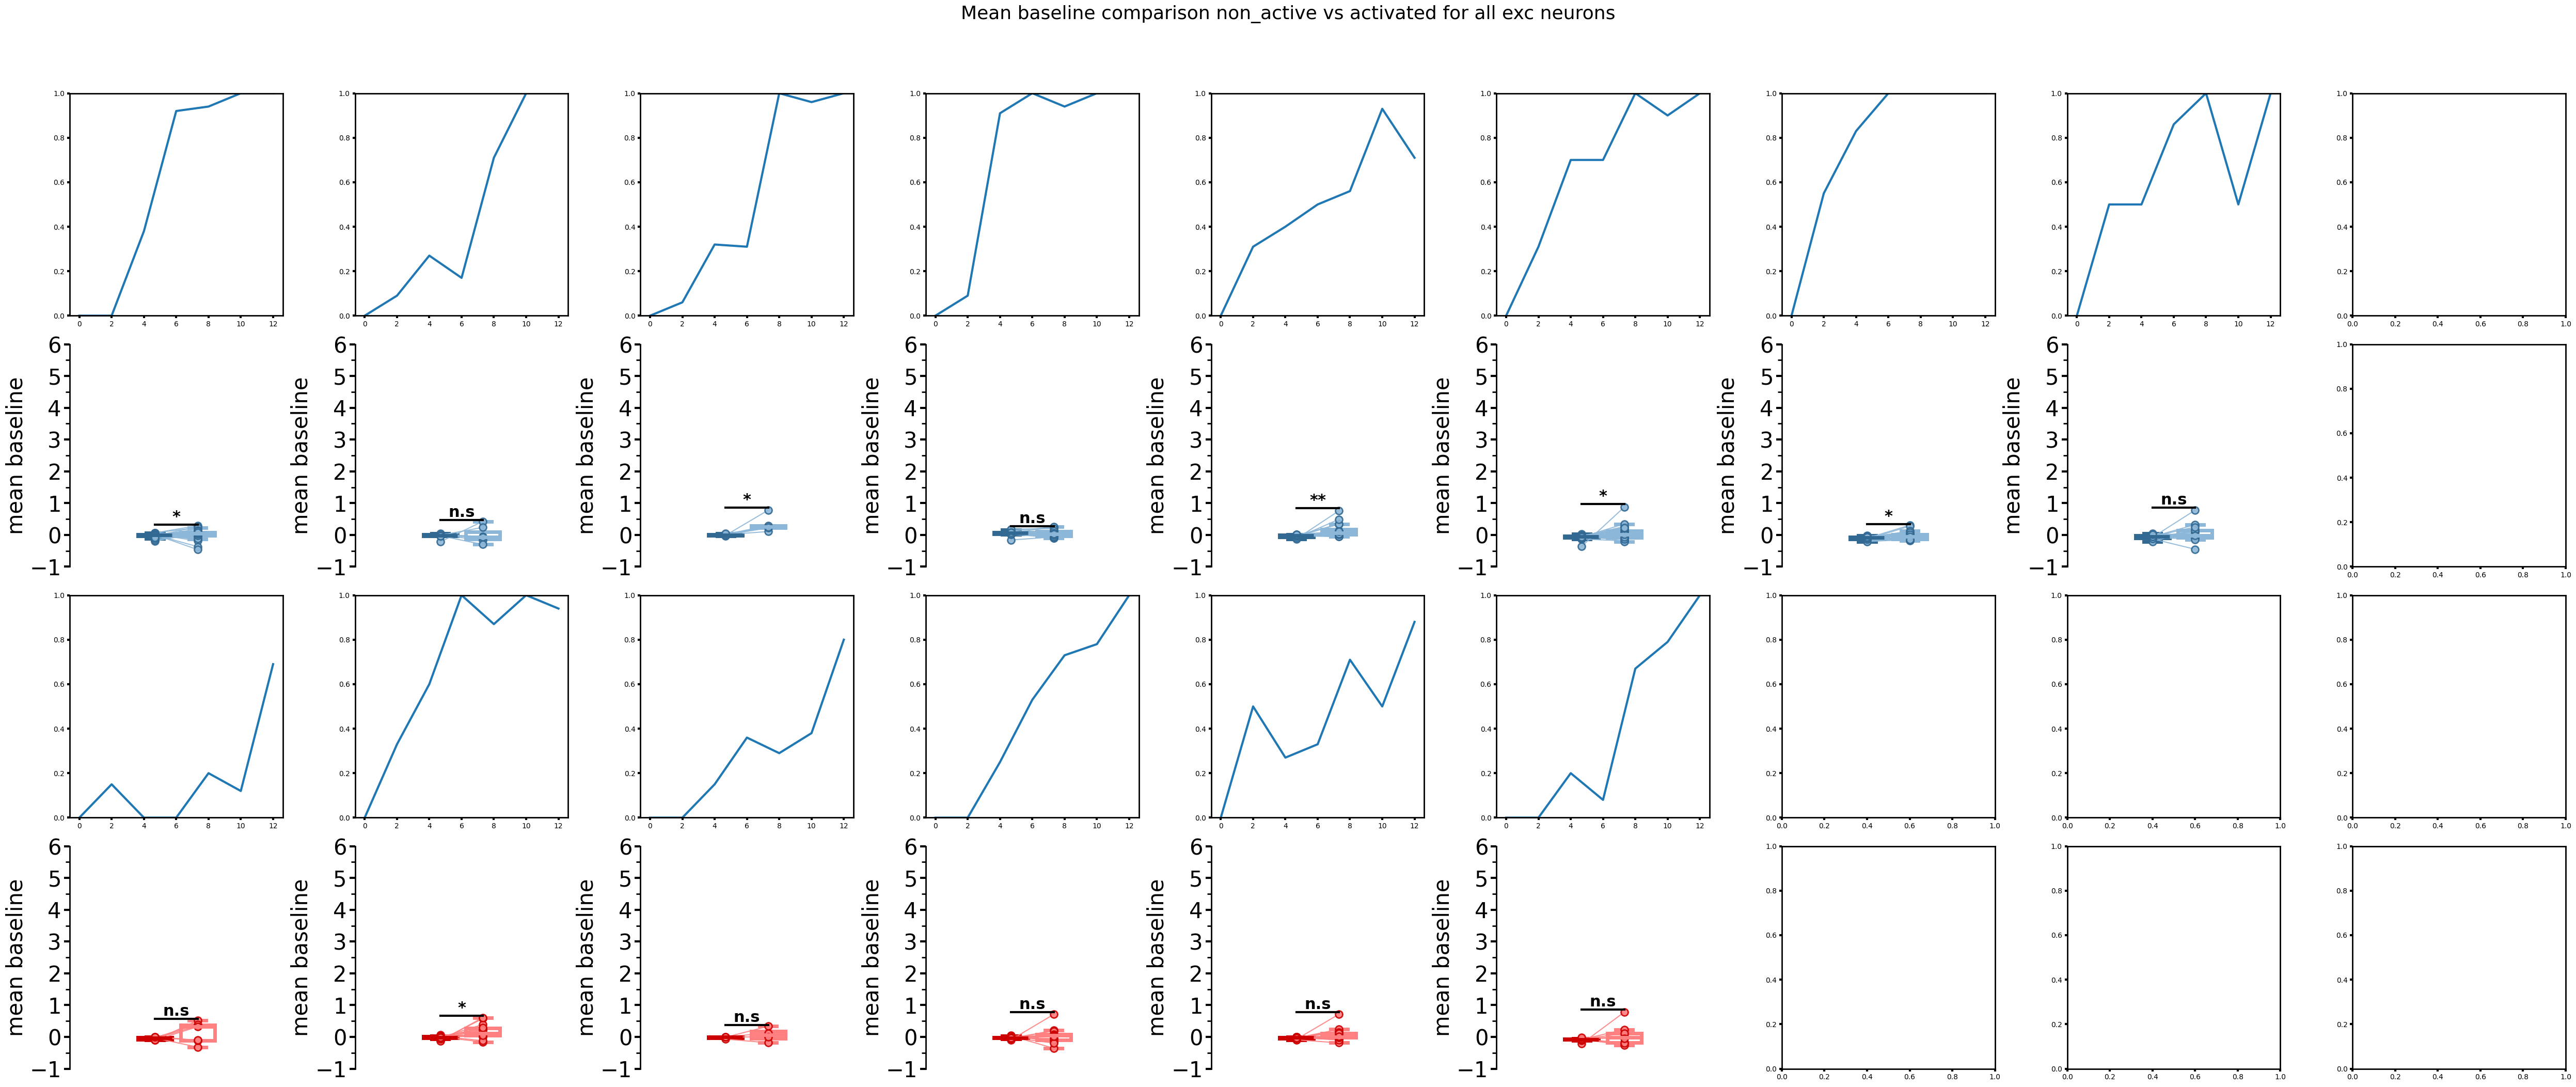

In [24]:
plot_diff_neuron_act(recs, n_type="EXC", first_group=0, second_group=1,y_lim=[-1,6], responsive_neur=True)

Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9355791657711221, pvalue=0.5992797121956719)
ShapiroResult(statistic=0.9748784690935863, pvalue=0.9311891876472052)
TtestResult(statistic=-4.423875589997422, pvalue=0.0044523318377679404, df=6)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9495482936383968, pvalue=0.09331972110152978)
ShapiroResult(statistic=0.9141004943448529, pvalue=0.007441553668215857)
WilcoxonResult(statistic=73.0, pvalue=5.546273314394057e-06)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9182452253917299, pvalue=0.4558842017511326)
ShapiroResult(statistic=0.9373136861212414, pvalue=0.6146560331865294)
TtestResult(statistic=-0.7429070197786057, pvalue=0.4855967846068988, df=6)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8444581564463891, pvalue=0.014509657599046998)
ShapiroResult(statistic=0.7721010520208873, pvalue=0.0016479247391479066)
WilcoxonResult(statistic=43.0, pvalue=0.359130859

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


--- mean baseline ---
ShapiroResult(statistic=0.773855390575916, pvalue=0.010233033975355847)
ShapiroResult(statistic=0.9259177352392446, pvalue=0.4434691077868634)
WilcoxonResult(statistic=8.0, pvalue=0.09765625)


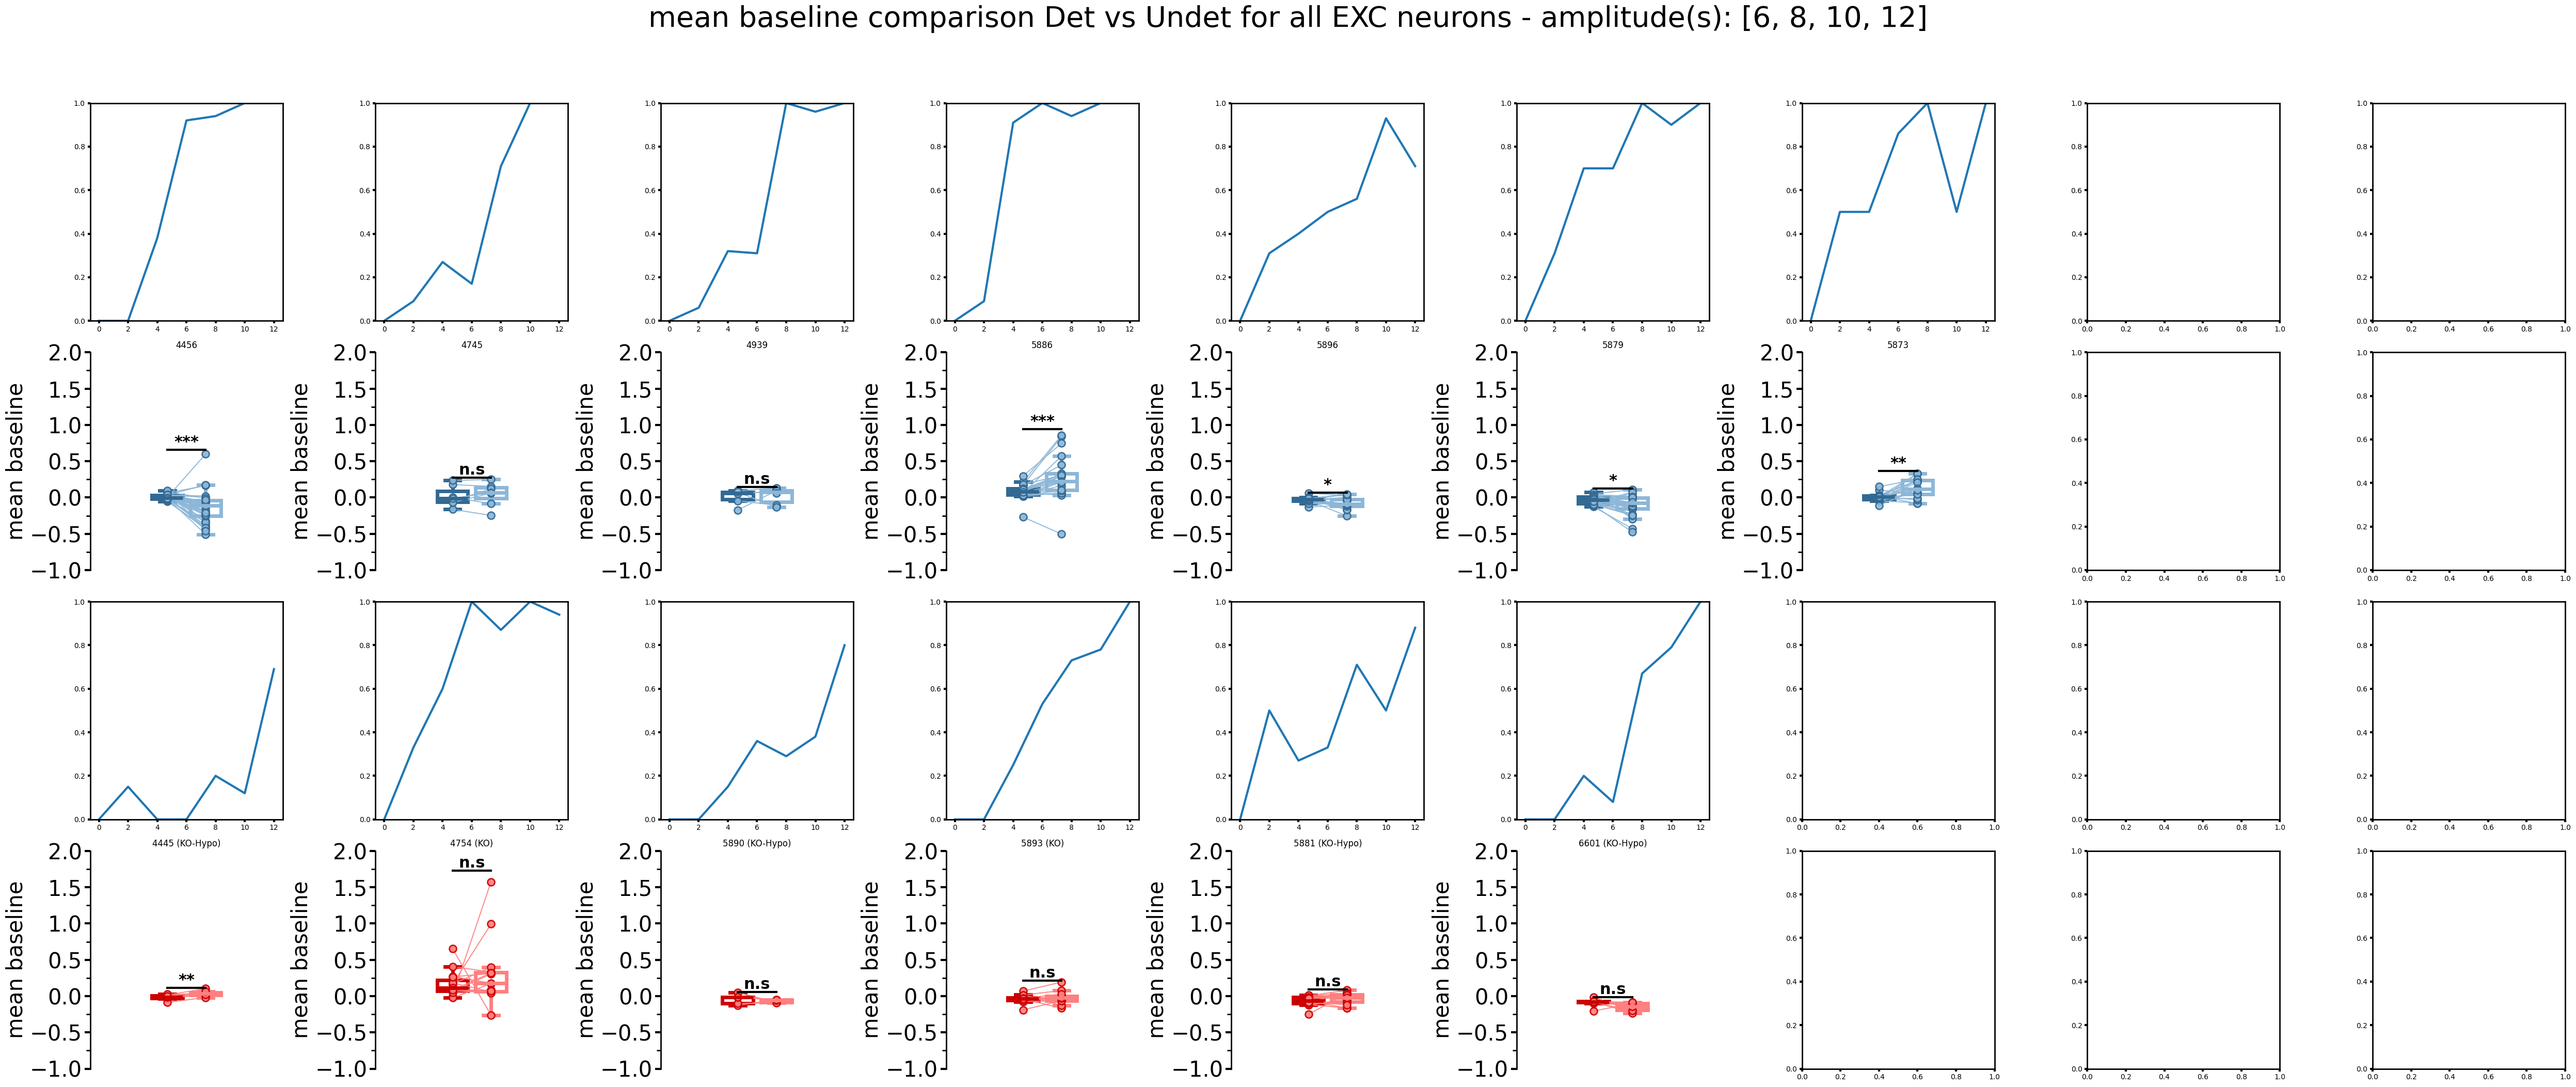

In [25]:
plot_baseline_comparison(recs, n_type="EXC", approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,2], responsive_neur=True)

 Check if there is differences of cross correlation in the baseline activity before the stim 

(98, 60)
(127, 90)
(125, 120)
(131, 90)
(42, 240)
(101, 60)
(66, 60)
(38, 330)
(76, 240)
(58, 120)
(55, 330)
(49, 330)
(91, 90)
(103, 150)
(51, 120)
(103, 60)
(62, 0)
(84, 0)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8389510836678132, pvalue=0.056222755224507336)
ShapiroResult(statistic=0.8544060804638729, pvalue=0.08330591050007244)
TtestResult(statistic=1.4675387522532222, pvalue=0.180411326100511, df=8)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8976377161018696, pvalue=0.3969672717287293)
ShapiroResult(statistic=0.934756481446076, pvalue=0.6291446345091924)
TtestResult(statistic=5.474156146690008, pvalue=0.005419421161834353, df=4)
(98, 450)
(127, 1650)
(125, 630)
(131, 270)
(42, 1590)
(101, 690)
(66, 630)
(38, 1620)
(76, 900)
(58, 990)
(55, 1020)
(49, 1050)
(91, 480)
(103, 570)
(51, 510)
(103, 780)
(62, 180)
(84, 270)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9161049608268144, pvalue=0.3990624361539094)
Shapiro

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


TtestResult(statistic=-3.6083315922535935, pvalue=0.008643357124532207, df=7)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9175750553388247, pvalue=0.4507920490477793)
ShapiroResult(statistic=0.827486707741323, pvalue=0.07573910319706666)
TtestResult(statistic=1.329542698710496, pvalue=0.23198203669946152, df=6)
(14, 60)
(14, 90)
(20, 120)
(12, 90)
(5, 240)
(19, 60)
(20, 60)
(9, 330)
(10, 240)
(13, 120)
(18, 330)
(15, 330)
(29, 90)
(19, 150)
(15, 120)
(22, 60)
(8, 0)
(18, 0)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.7737728394443653, pvalue=0.010210633906240647)
ShapiroResult(statistic=0.8728419675856585, pvalue=0.13186319404324864)
WilcoxonResult(statistic=20.0, pvalue=0.8203125)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.8146888759355205, pvalue=0.10617861490428893)
ShapiroResult(statistic=0.9114824291892666, pvalue=0.47655002233213184)
TtestResult(statistic=6.185616283056502, pvalue=0.0034713525323874627, df=4)
(14,

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


--- mean baseline ---
ShapiroResult(statistic=0.9244657524321948, pvalue=0.5048753523780769)
ShapiroResult(statistic=0.9039001492812659, pvalue=0.355255767069079)
TtestResult(statistic=1.364064283334452, pvalue=0.22149788551023533, df=6)


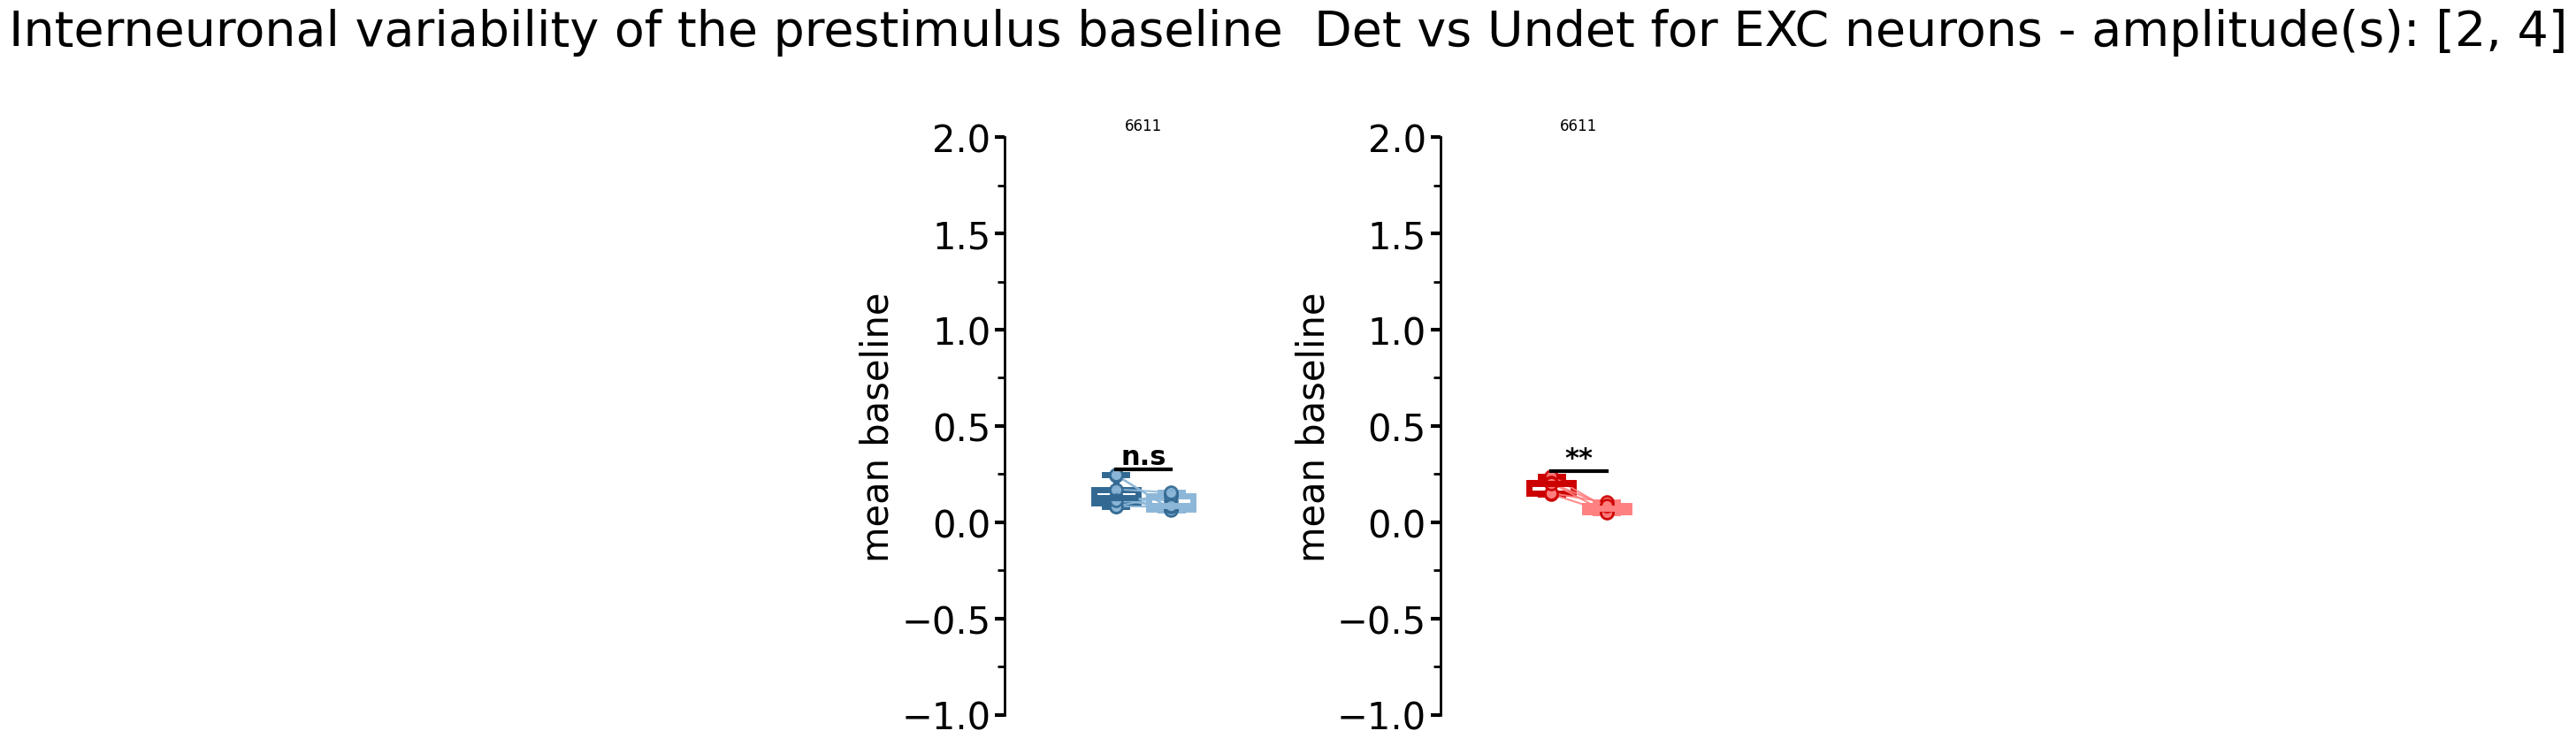

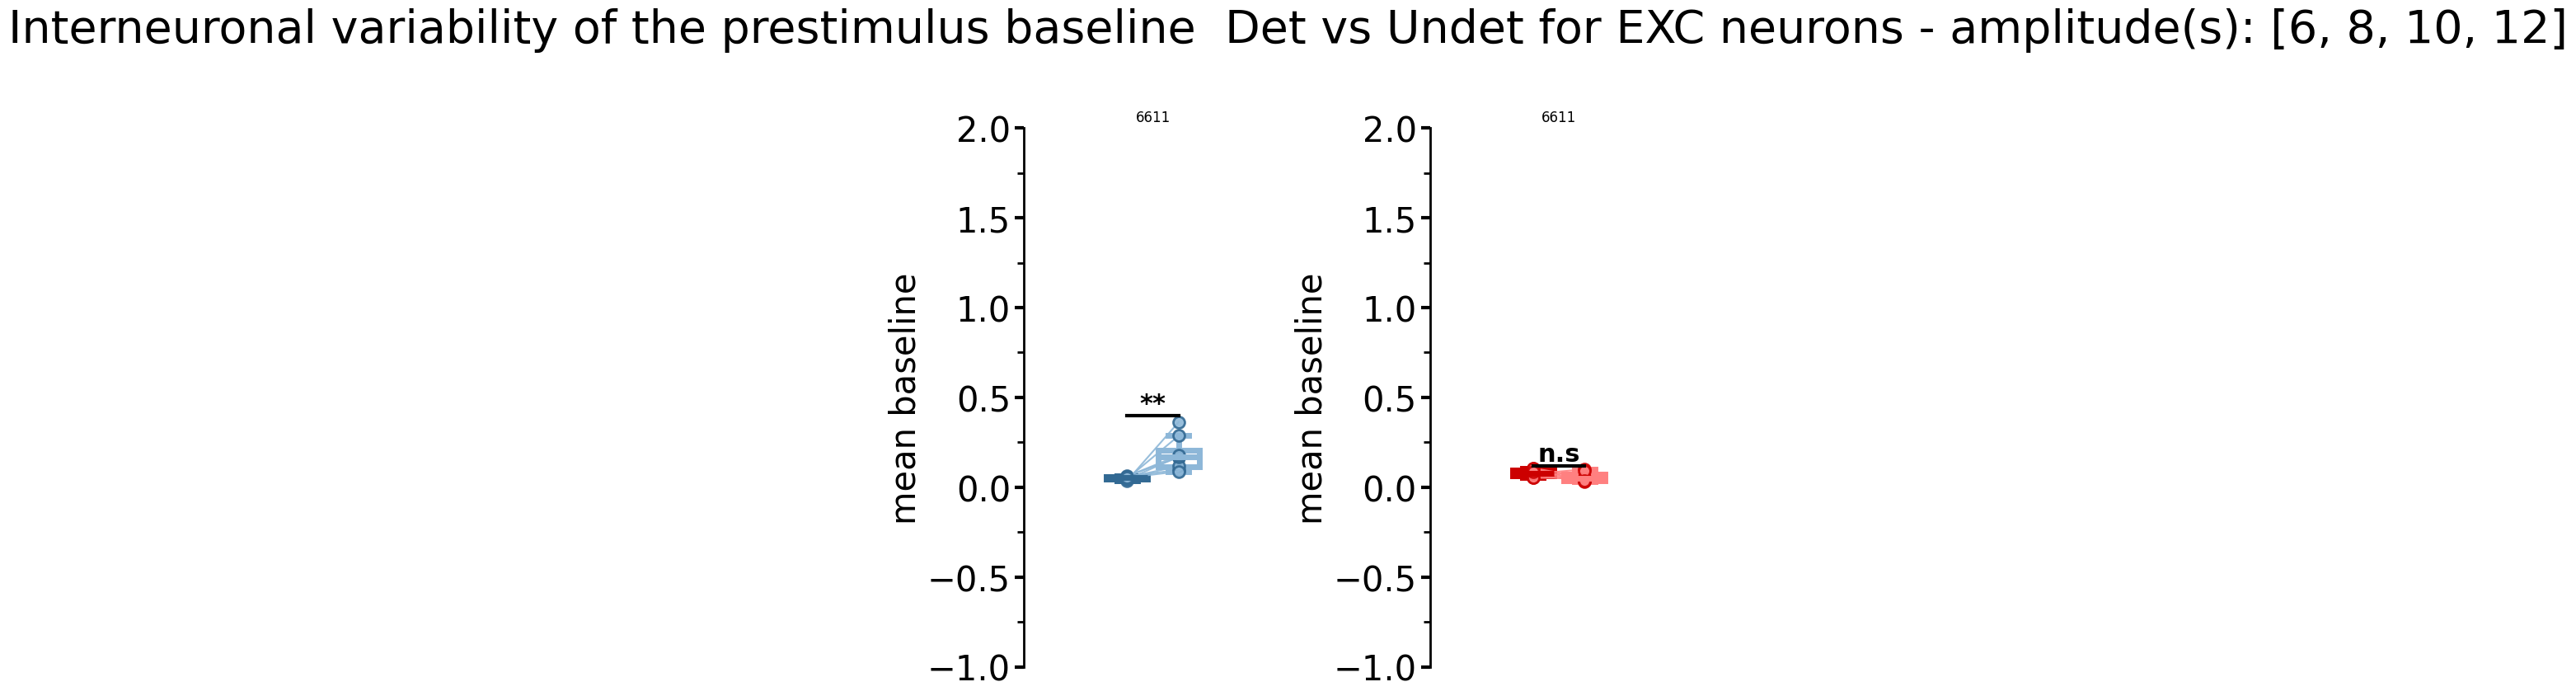

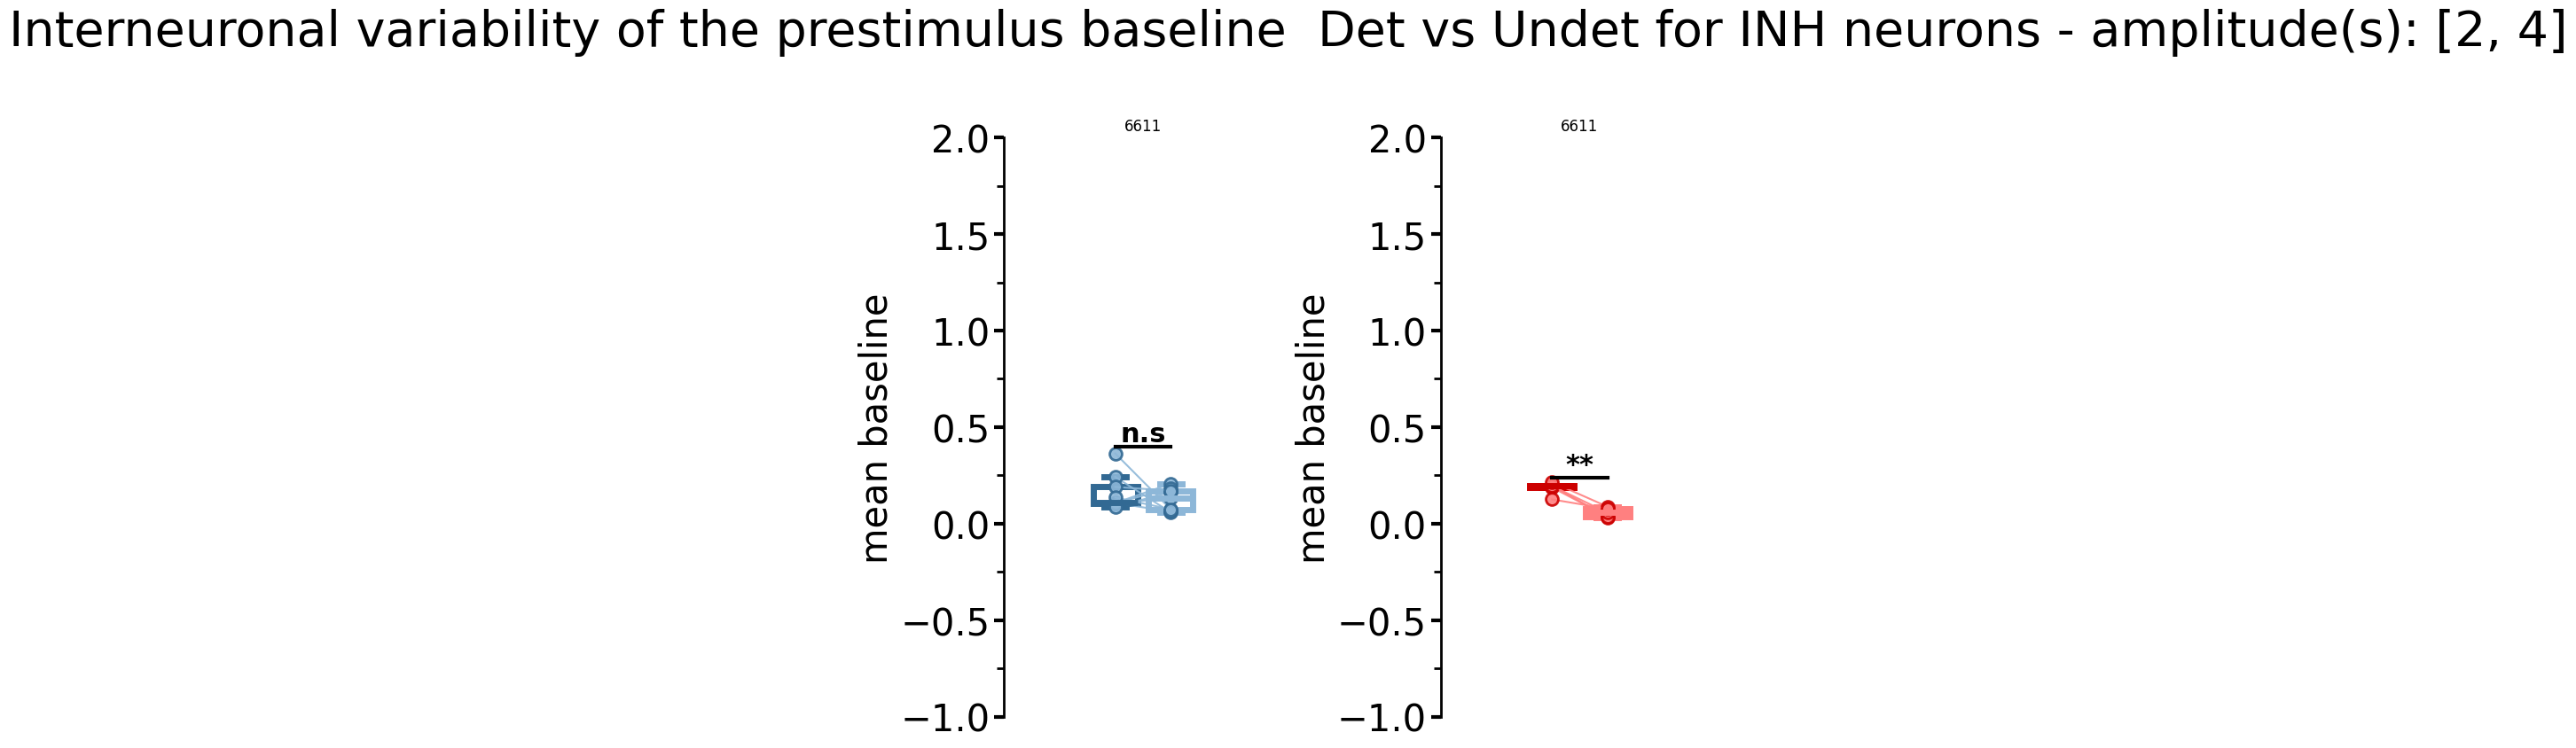

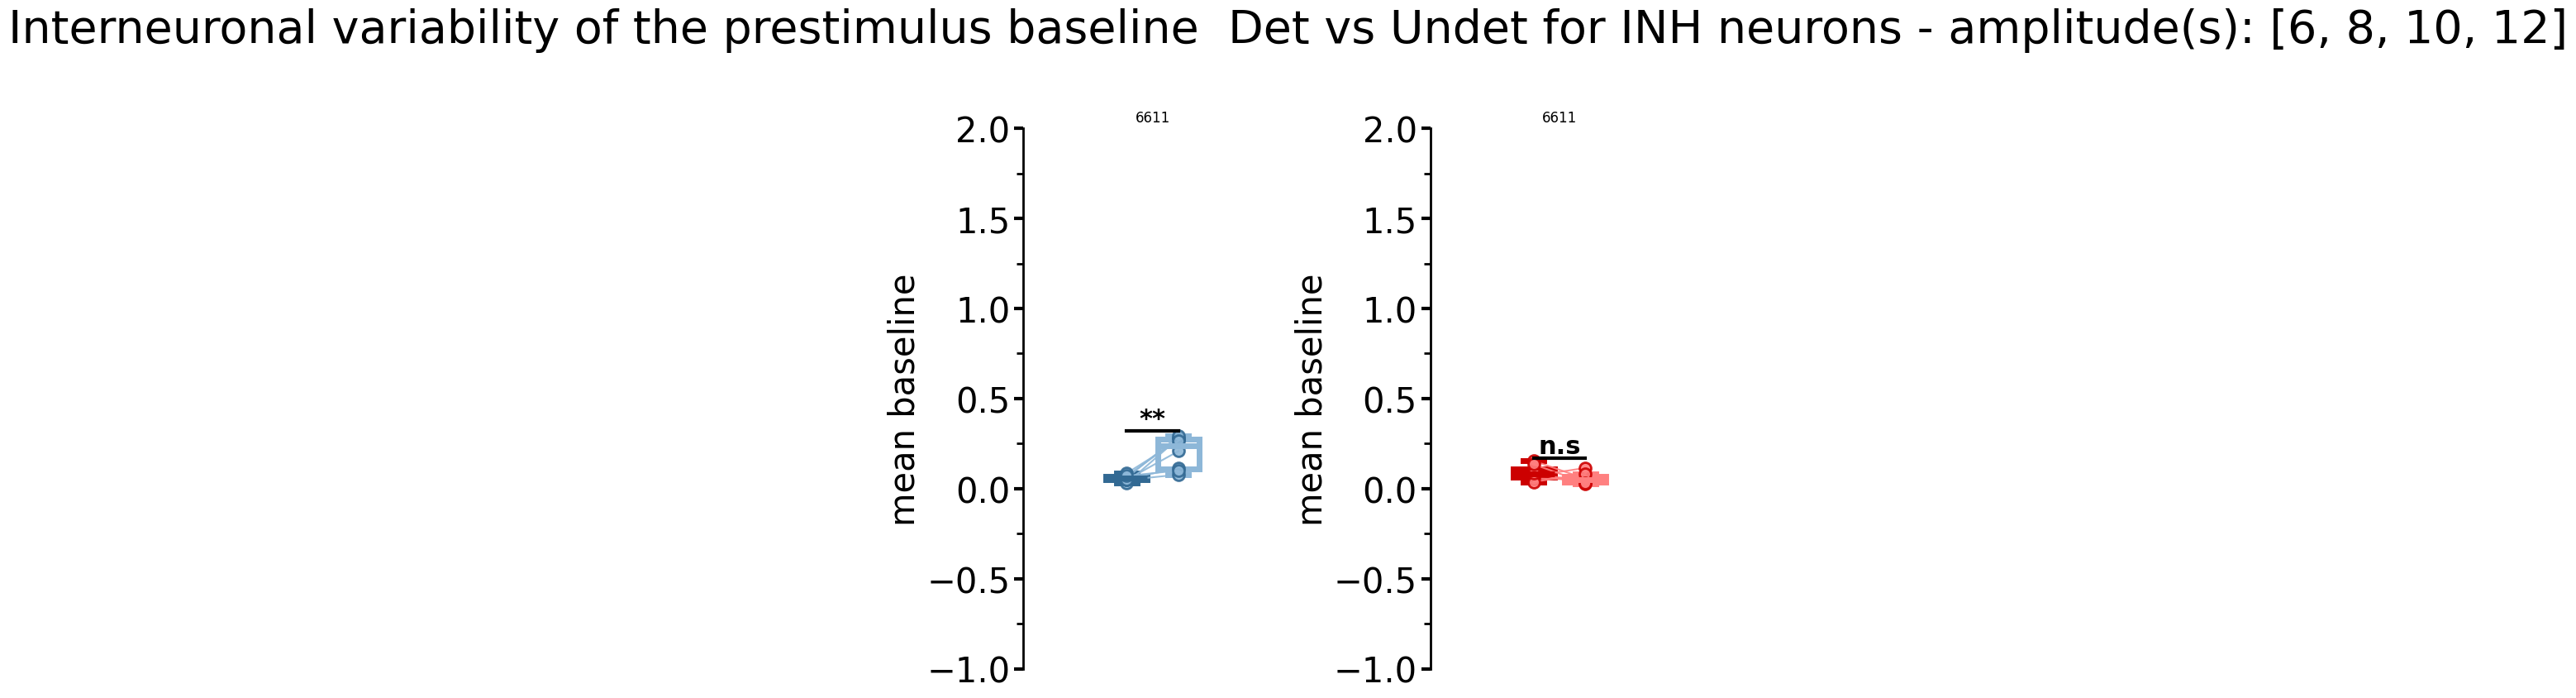

In [30]:
def plot_baseline_correlation(recs, n_type="EXC",signal="zscore", approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[], responsive_neur=False):
    bsl_window = 1
    wt_det, wt_undet, ko_det, ko_undet= [],[],[],[]
    for rec in recs.values():
            if signal == "zscore":
                trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
            elif signal == "dff_f":
                trace = rec.df_f_exc if n_type == "EXC" else rec.dff_f_inh
            if only_mlr_signif:
                mlr_model, model_name = mlr_m.precise_stim_model(rec)
                rec.mlr(mlr_model, model_name)
                trace = trace[rec.mlr_labels_exc["indices_r2"]] if n_type == "EXC" else trace[rec.mlr_labels_inh["indices_r2"]]
            if responsive_neur:
                ids_resp, ids_inh = idx_resp_neur(rec, n_type=n_type)
                if len(ids_resp)<3:
                    continue
                trace = trace[ids_resp] if n_type == "EXC" else trace[ids_resp]
            
            #  get all the bsl before stim of the corresponding amp stim
            det_amp_filter = np.logical_and(rec.detected_stim, rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_det = rec.stim_time[det_amp_filter]
            bsl_det = trace[:, np.linspace(stims_det - int(bsl_window * rec.sf), stims_det, int(bsl_window * rec.sf), dtype=int)]
            r_bsl_d = bsl_det.reshape(len(trace), len(stims_det) * int(bsl_window * rec.sf))
            print(r_bsl_d.shape)
            
            undet_amp_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_undet = rec.stim_time[undet_amp_filter]
            bsl_undet = trace[:, np.linspace(stims_undet - int(bsl_window * rec.sf), stims_undet, int(bsl_window * rec.sf), dtype=int)]
            r_bsl_u = bsl_undet.reshape(len(trace), len(stims_undet) * int(bsl_window * rec.sf))
            
            if approx == "mean":
                det_bsl = np.mean(np.std(np.mean(r_bsl_d, axis=1), axis=0))
                undet_bsl = np.mean(np.std(np.mean(r_bsl_u, axis=1),axis=0))
            elif approx == "std":
                det_bsl = np.mean(np.std(np.std(r_bsl_d, axis=1),axis=0))
                undet_bsl = np.mean(np.std(np.std(r_bsl_u, axis=1),axis=0))
            if np.isnan(undet_bsl):
                continue
            if rec.genotype == "WT":
                wt_det.append(det_bsl)
                wt_undet.append(undet_bsl)
            elif rec.genotype== "KO-Hypo":
                ko_det.append(det_bsl)
                ko_undet.append(undet_bsl)


    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    # print(wt_det, wt_undet)
    # print("ko")
    # print(ko_det, ko_undet)
    wt_nan =np.logical_and(~np.isnan(wt_det),~np.isnan(wt_undet))
    ko_nan =np.logical_and(~np.isnan(ko_det),~np.isnan(ko_undet))
    # print(wt_nan)
    ppt.paired_boxplot(ax[0],np.array(wt_det)[wt_nan], np.array(wt_undet)[wt_nan], f"{approx} baseline", rec.filename,colors=[ppt.wt_color, ppt.light_wt_color], ylim=ylim, allow_stats_skip=True)
    ppt.paired_boxplot(ax[1], np.array(ko_det)[ko_nan], np.array(ko_undet)[ko_nan], f"{approx} baseline", rec.filename,colors=[ppt.ko_color, ppt.light_ko_color], ylim=ylim)

    fig.suptitle(f"Interneuronal variability of the prestimulus baseline  Det vs Undet for {n_type} neurons - amplitude(s): {stim_ampl}", y=1.05,fontsize=40)
    fig.tight_layout()
    
plot_baseline_correlation(recs, n_type="EXC", approx="mean", stim_ampl=below_wt_threshold, only_mlr_signif=False, ylim=[-1,2], responsive_neur=False)
plot_baseline_correlation(recs, n_type="EXC", approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,2], responsive_neur=False)
plot_baseline_correlation(recs, n_type="INH", approx="mean", stim_ampl=below_wt_threshold, only_mlr_signif=False, ylim=[-1,2], responsive_neur=False)
plot_baseline_correlation(recs, n_type="INH", approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[-1,2], responsive_neur=False)

trace.shape: (98, 30001)
new_columns: (98, 30)
new_columns: (98, 30)
r_bsl_d: (98, 2)
trace.shape: (127, 27843)
new_columns: (127, 30)
new_columns: (127, 30)
new_columns: (127, 30)
r_bsl_d: (127, 3)
trace.shape: (125, 29549)
new_columns: (125, 30)
new_columns: (125, 30)
new_columns: (125, 30)
new_columns: (125, 30)
r_bsl_d: (125, 4)
trace.shape: (131, 30727)
new_columns: (131, 30)
new_columns: (131, 30)
new_columns: (131, 30)
r_bsl_d: (131, 3)
trace.shape: (42, 27114)
new_columns: (42, 30)
new_columns: (42, 30)
new_columns: (42, 30)
new_columns: (42, 30)
new_columns: (42, 30)
new_columns: (42, 30)
new_columns: (42, 30)
new_columns: (42, 30)
r_bsl_d: (42, 8)
trace.shape: (101, 28220)
new_columns: (101, 30)
new_columns: (101, 30)
r_bsl_d: (101, 2)
trace.shape: (66, 29730)
new_columns: (66, 30)
new_columns: (66, 30)
r_bsl_d: (66, 2)
trace.shape: (38, 26770)
new_columns: (38, 30)
new_columns: (38, 30)
new_columns: (38, 30)
new_columns: (38, 30)
new_columns: (38, 30)
new_columns: (38, 30)
n

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--- mean baseline ---
ShapiroResult(statistic=0.914816491043804, pvalue=0.3510548148581645)
ShapiroResult(statistic=0.9262763566609394, pvalue=0.44671534884550906)
TtestResult(statistic=-0.8641661330270818, pvalue=0.41265598627378486, df=8)
Boxplot plotting.
--- mean baseline ---
ShapiroResult(statistic=0.9213277730283301, pvalue=0.4797787155667481)
ShapiroResult(statistic=0.9257047045100681, pvalue=0.5149898085671585)
TtestResult(statistic=0.5977469034998178, pvalue=0.5718638009619543, df=6)
trace.shape: (14, 30001)
new_columns: (14, 30)
new_columns: (14, 30)
r_bsl_d: (14, 2)
trace.shape: (14, 27843)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
r_bsl_d: (14, 3)
trace.shape: (20, 29549)
new_columns: (20, 30)
new_columns: (20, 30)
new_columns: (20, 30)
new_columns: (20, 30)
r_bsl_d: (20, 4)
trace.shape: (12, 30727)
new_columns: (12, 30)
new_columns: (12, 30)
new_columns: (12, 30)
r_bsl_d: (12, 3)
trace.shape: (5, 27114)
new_columns: (5, 30)
new_columns: (5, 30)
new_

C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cvandromme\PycharmProjects\Percephone\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--- mean baseline ---
ShapiroResult(statistic=0.9871327369235298, pvalue=0.9687204060830029)
ShapiroResult(statistic=0.9894773665676732, pvalue=0.9778314148485872)
TtestResult(statistic=4.704230451266077, pvalue=0.00927925849696159, df=4)
trace.shape: (14, 30001)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
r_bsl_d: (14, 15)
trace.shape: (14, 27843)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns: (14, 30)
new_columns

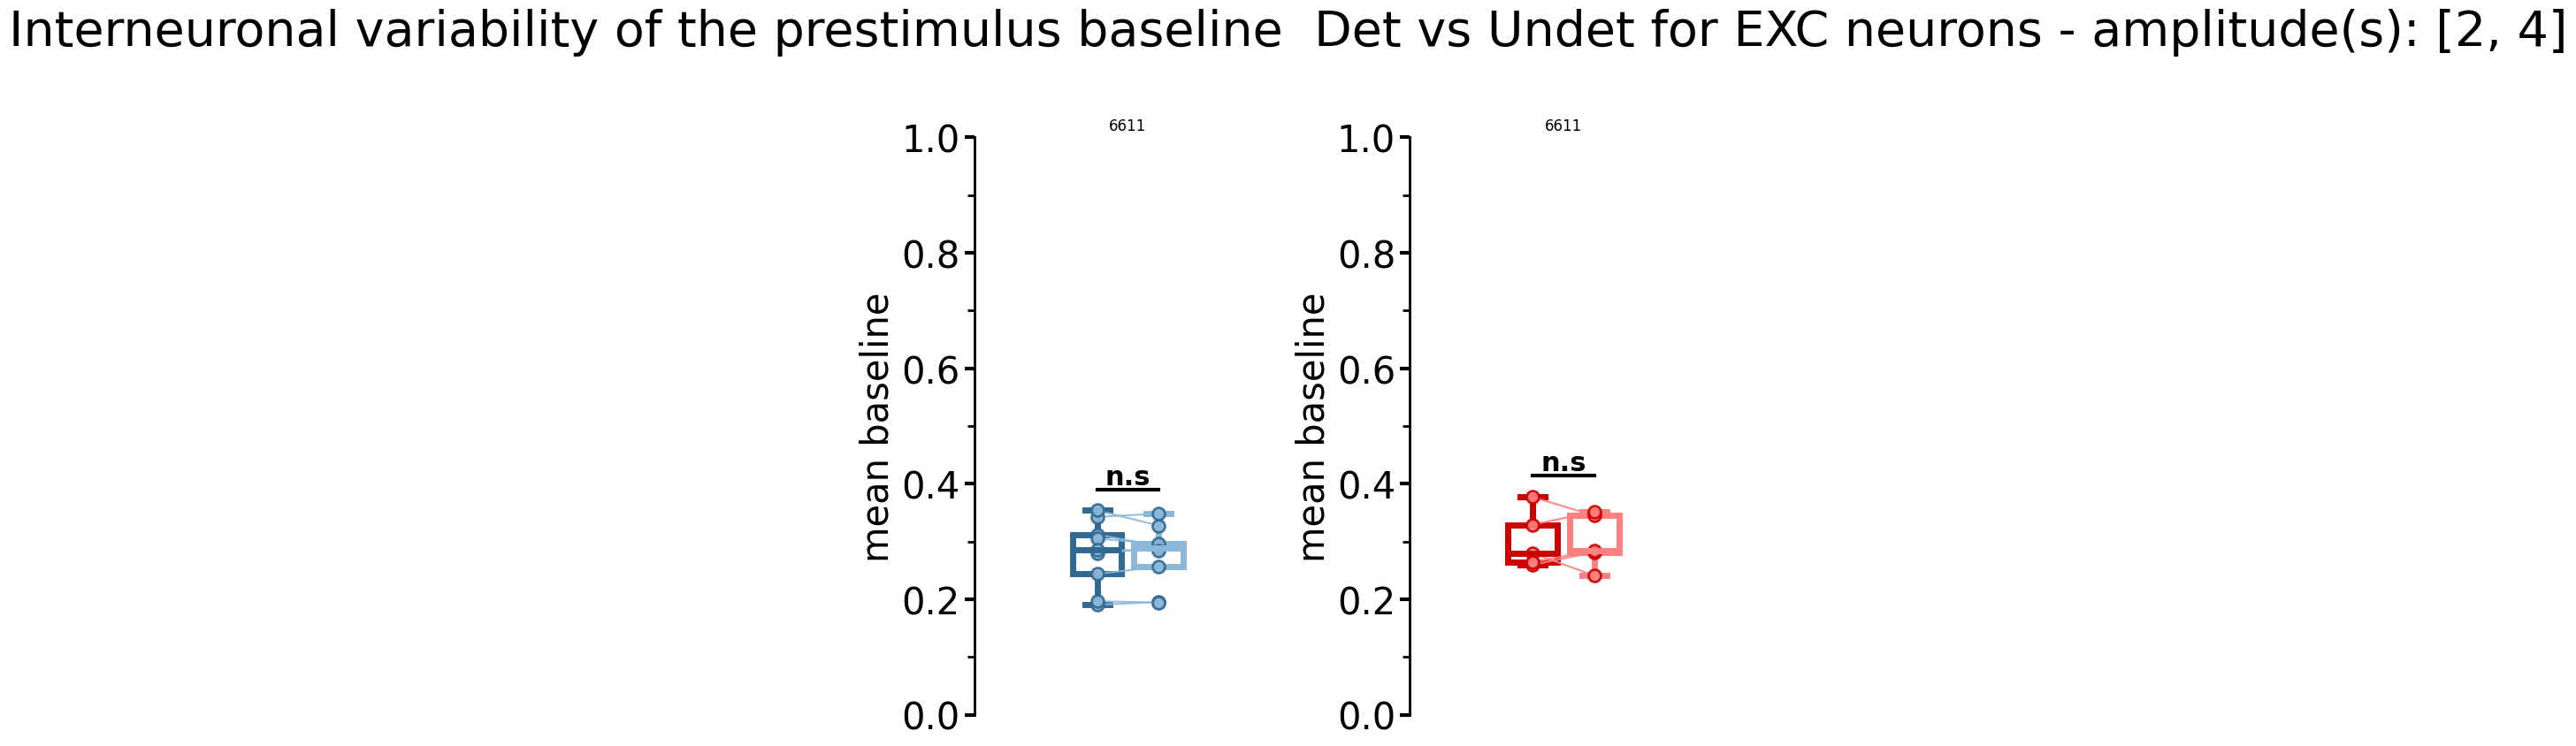

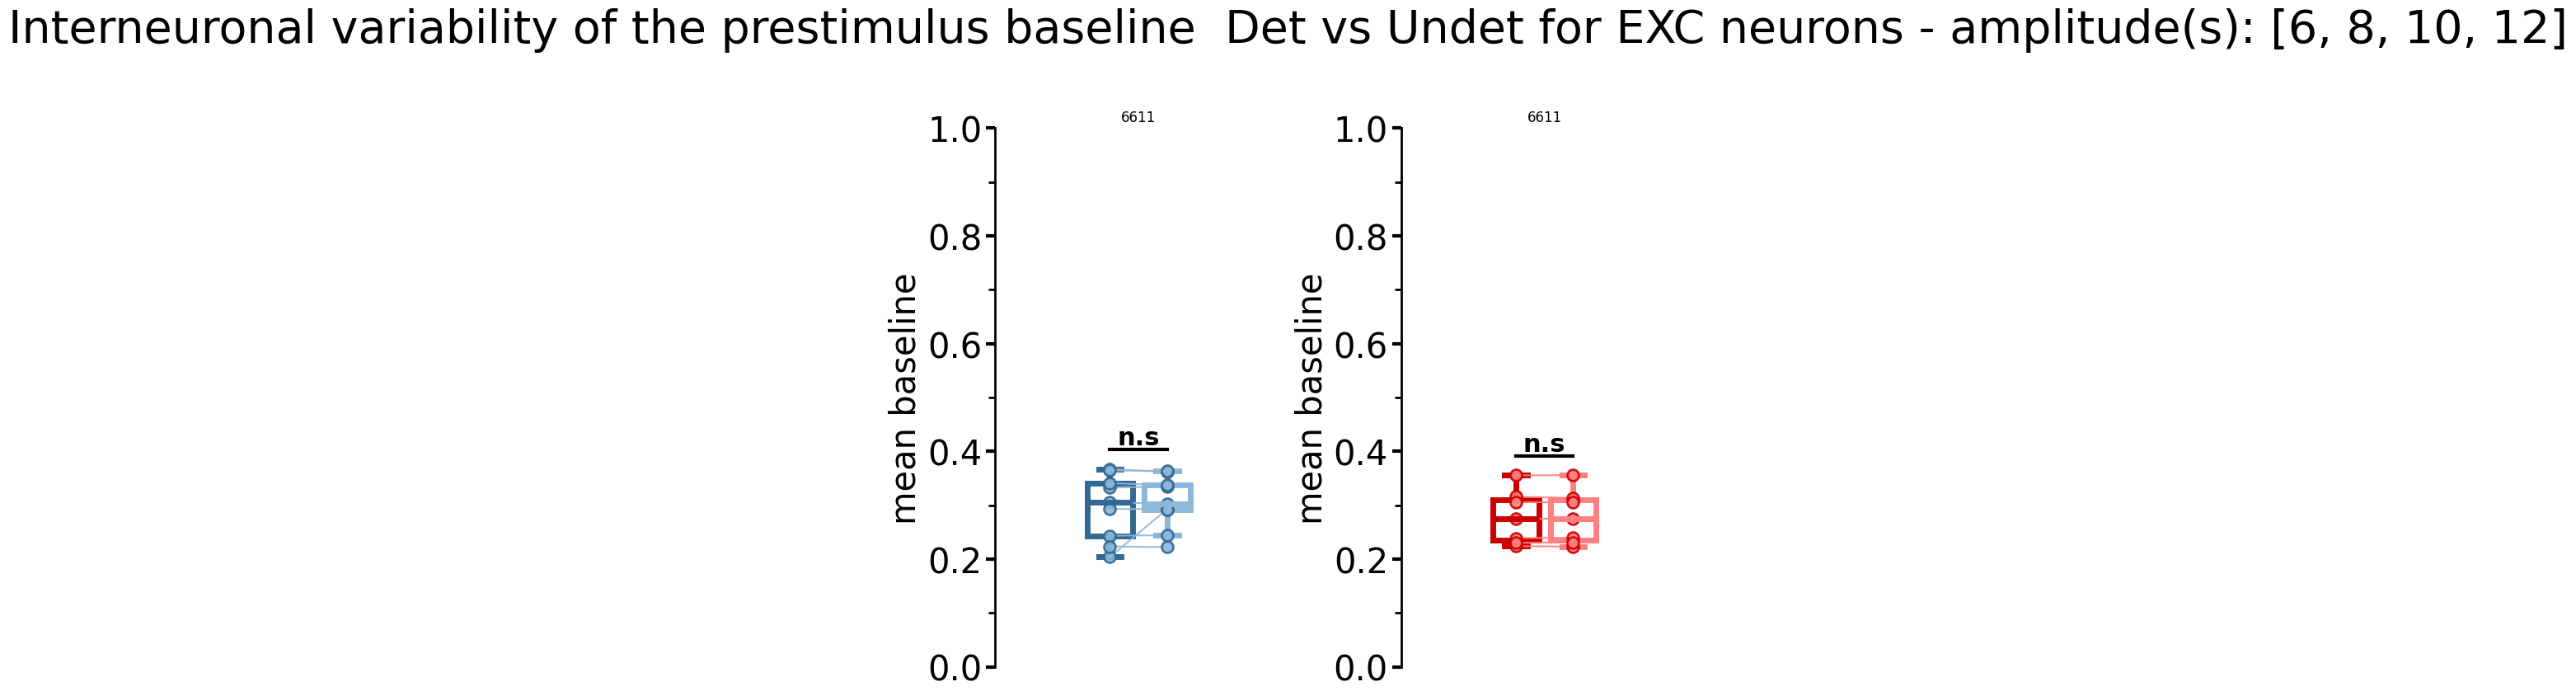

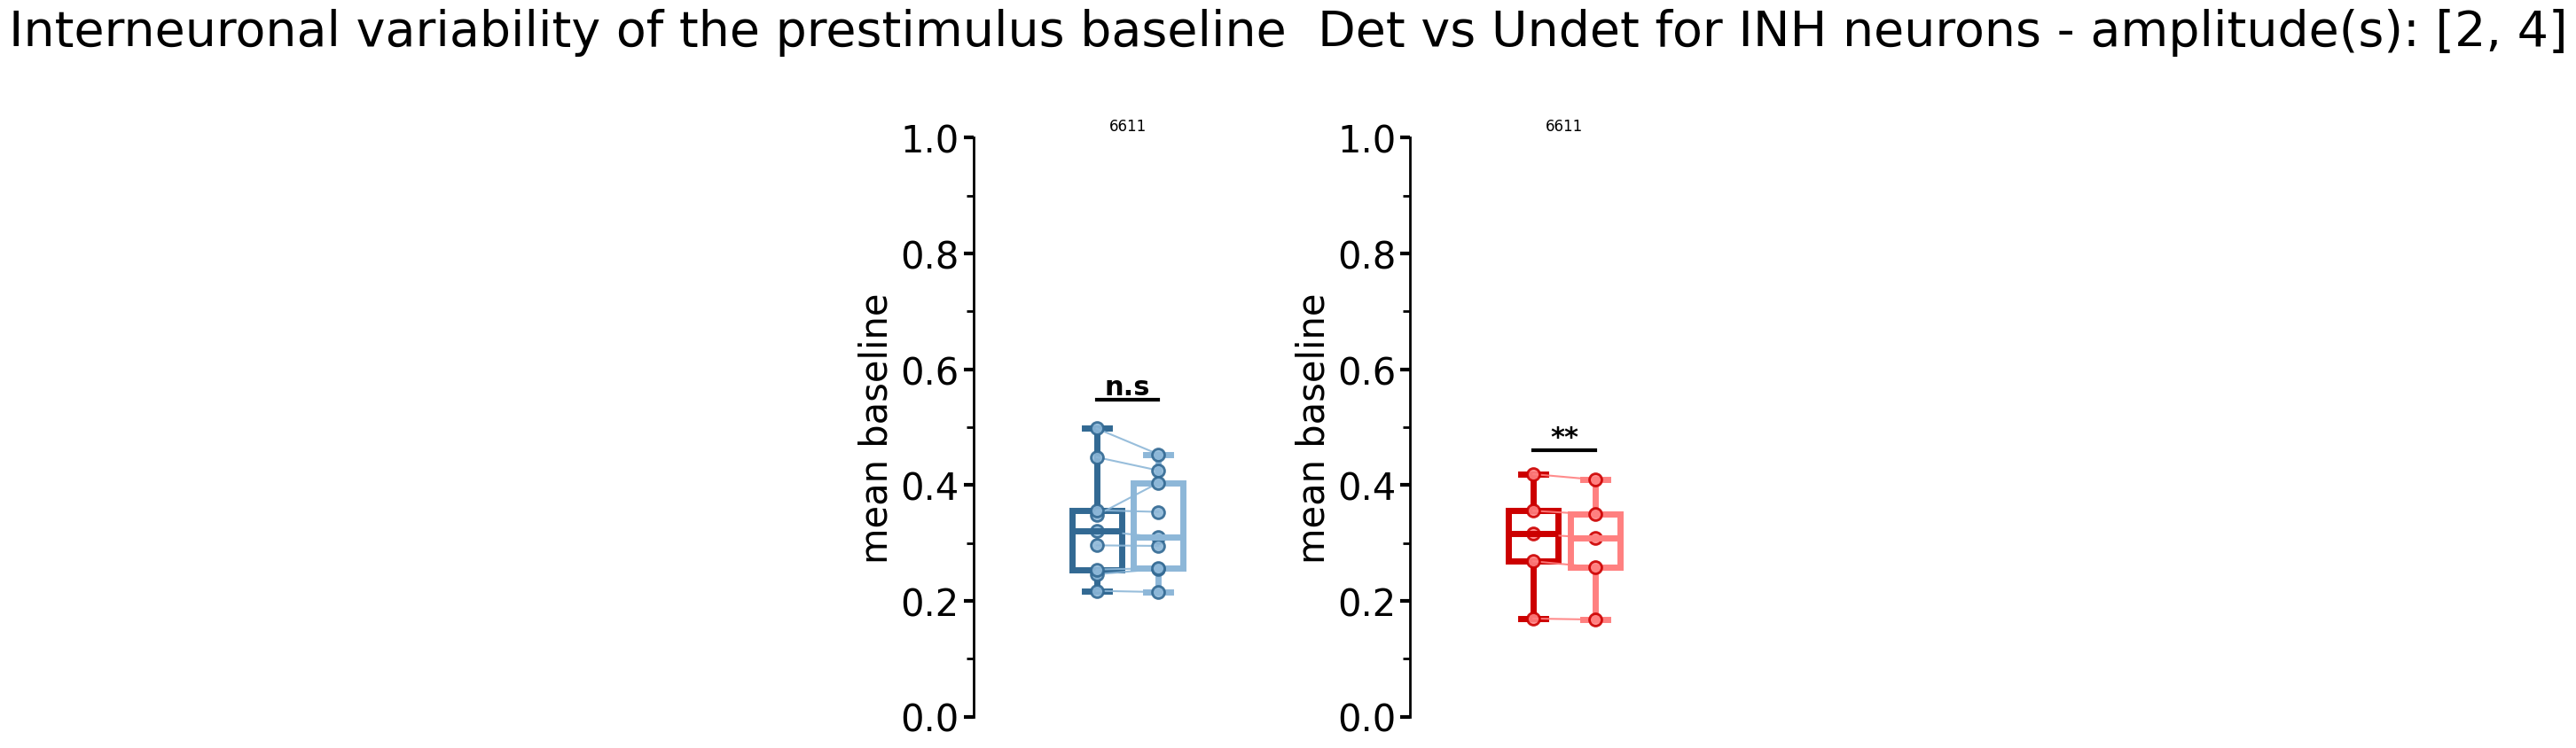

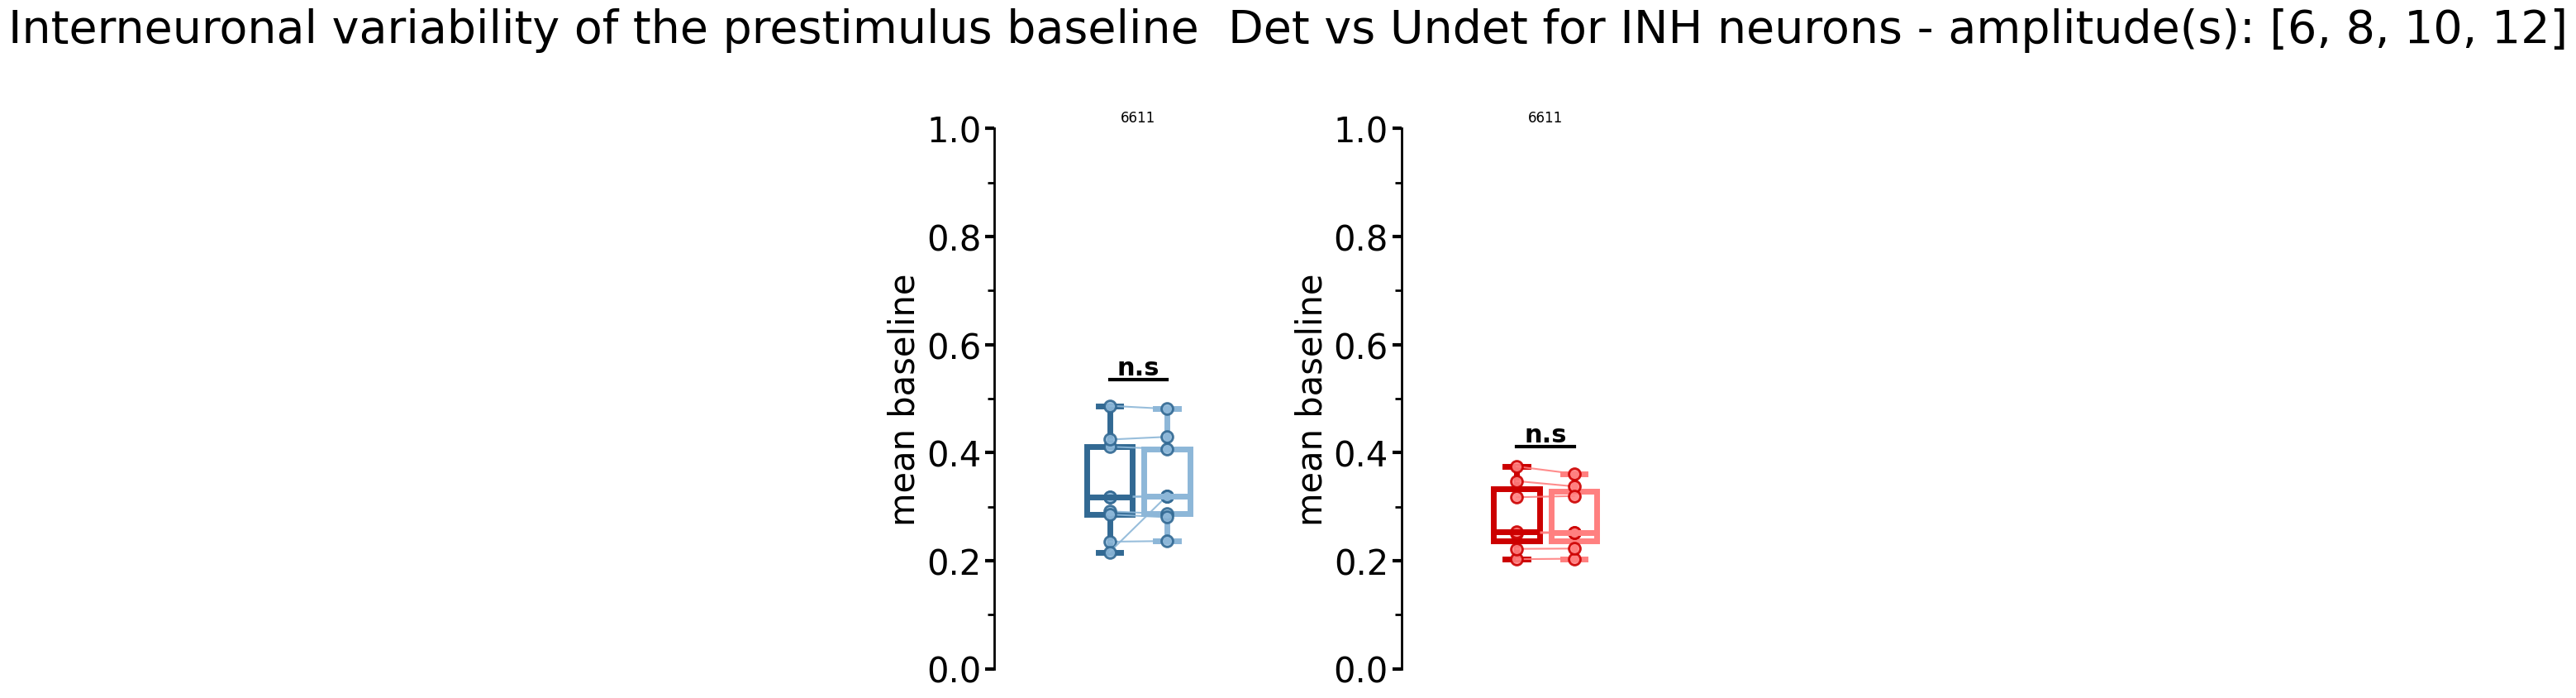

In [32]:
# Duplicate to verify
def plot_baseline_correlation(recs, n_type="EXC",signal="zscore", approx="mean", stim_ampl="threshold", only_mlr_signif=False, ylim=[], responsive_neur=False):
    bsl_window = 1
    wt_det, wt_undet, ko_det, ko_undet= [],[],[],[]
    for rec in recs.values():
            if signal == "zscore":
                trace = rec.zscore_exc if n_type == "EXC" else rec.zscore_inh
            elif signal == "dff_f":
                trace = rec.df_f_exc if n_type == "EXC" else rec.dff_f_inh
            if only_mlr_signif:
                mlr_model, model_name = mlr_m.precise_stim_model(rec)
                rec.mlr(mlr_model, model_name)
                trace = trace[rec.mlr_labels_exc["indices_r2"]] if n_type == "EXC" else trace[rec.mlr_labels_inh["indices_r2"]]
            if responsive_neur:
                ids_resp, ids_inh = idx_resp_neur(rec, n_type=n_type)
                if len(ids_resp)<3:
                    continue
                trace = trace[ids_resp] if n_type == "EXC" else trace[ids_resp]
            
            #  get all the bsl before stim of the corresponding amp stim
            det_amp_filter = np.logical_and(rec.detected_stim, rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_det = rec.stim_time[det_amp_filter]
            bsl_det = np.empty((trace.shape[0], 0))
            print(f"trace.shape: {trace.shape}")
            for stim in stims_det:
                new_columns = trace[:, stim - int(bsl_window * rec.sf) : stim]
                new_col = np.mean(new_columns, axis=1)
                print(f"new_columns: {new_columns.shape}")
                bsl_det = np.column_stack((bsl_det, new_col))
               
            # bsl_det = trace[:, np.linspace(stims_det - int(bsl_window * rec.sf), stims_det, int(bsl_window * rec.sf), dtype=int)]
            # r_bsl_d = bsl_det.reshape(len(trace), len(stims_det) * int(bsl_window * rec.sf))
            r_bsl_d = bsl_det
            print(f"r_bsl_d: {r_bsl_d.shape}")
            
            undet_amp_filter = np.logical_and(np.invert(rec.detected_stim), rec.stim_ampl_filter(stim_ampl=stim_ampl, include_no_go=False))
            stims_undet = rec.stim_time[undet_amp_filter]
            for stim in stims_undet:
                new_columns = trace[:, stim - int(bsl_window * rec.sf) : stim]
                new_col = np.mean(new_columns, axis=1)
                bsl_undet = np.column_stack((bsl_det, new_col))
            # bsl_undet = trace[:, np.linspace(stims_undet - int(bsl_window * rec.sf), stims_undet, int(bsl_window * rec.sf), dtype=int)]
            # r_bsl_u = bsl_undet.reshape(len(trace), len(stims_undet) * int(bsl_window * rec.sf))
            r_bsl_u = bsl_undet
            
            if approx == "mean":
                det_bsl = np.mean(np.std(r_bsl_d, axis=0))
                undet_bsl = np.mean(np.std(r_bsl_u, axis=0))
            elif approx == "std":
                det_bsl = np.mean(np.std(np.std(r_bsl_d, axis=1),axis=0))
                undet_bsl = np.mean(np.std(np.std(r_bsl_u, axis=1),axis=0))
            if np.isnan(undet_bsl):
                continue
            if rec.genotype == "WT":
                wt_det.append(det_bsl)
                wt_undet.append(undet_bsl)
            elif rec.genotype== "KO-Hypo":
                ko_det.append(det_bsl)
                ko_undet.append(undet_bsl)


    fig, ax = plt.subplots(1, 2, figsize=(10, 8))
    # print(wt_det, wt_undet)
    # print("ko")
    # print(ko_det, ko_undet)
    wt_nan =np.logical_and(~np.isnan(wt_det),~np.isnan(wt_undet))
    ko_nan =np.logical_and(~np.isnan(ko_det),~np.isnan(ko_undet))
    # print(wt_nan)
    ppt.paired_boxplot(ax[0],np.array(wt_det)[wt_nan], np.array(wt_undet)[wt_nan], f"{approx} baseline", rec.filename,colors=[ppt.wt_color, ppt.light_wt_color], ylim=ylim, allow_stats_skip=True)
    ppt.paired_boxplot(ax[1], np.array(ko_det)[ko_nan], np.array(ko_undet)[ko_nan], f"{approx} baseline", rec.filename,colors=[ppt.ko_color, ppt.light_ko_color], ylim=ylim)

    fig.suptitle(f"Interneuronal variability of the prestimulus baseline  Det vs Undet for {n_type} neurons - amplitude(s): {stim_ampl}", y=1.05,fontsize=40)
    fig.tight_layout()
    
plot_baseline_correlation(recs, n_type="EXC", approx="mean", stim_ampl=below_wt_threshold, only_mlr_signif=False, ylim=[0, 1], responsive_neur=False)
plot_baseline_correlation(recs, n_type="EXC", approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[0, 1], responsive_neur=False)
plot_baseline_correlation(recs, n_type="INH", approx="mean", stim_ampl=below_wt_threshold, only_mlr_signif=False, ylim=[0, 1], responsive_neur=False)
plot_baseline_correlation(recs, n_type="INH", approx="mean", stim_ampl=above_wt_threshold, only_mlr_signif=False, ylim=[0, 1], responsive_neur=False)